In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import random
import os




In [2]:
# Specify the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
   device = 'mps'

# Load the model and map it to the GPU
model = torch.load("saved_models/model_full_old.pth", map_location=device)
ray_model = torch.load("saved_models/model_full_with_rays.pth", map_location=device)

# Set the model to evaluation mode
model.eval()
#ray_model.eval()

print("Model loaded onto", device)

C:\Users\iacop\AppData\Local\Temp\ipykernel_22580\4136127815.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/model_full_old.pth", map_lo

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_full_old.pth'

In [ ]:
num_runs = 15
image_files = glob.glob('./data_new/*.png')

for run in range(num_runs):
    # Randomly select one image
    target_image_path = random.choice(image_files)
    target_image = Image.open(target_image_path).convert('L')
    target_image = pil_to_binary(target_image)
    # Save target image to plots directory
    os.makedirs(f"./plots/{run}", exist_ok=True)
    plt.imsave(f"./plots/{run}/target_image.png", target_image, cmap='gray')

    # Random agent simulation
    # Assuming target_image is a numpy array or similar object
    width, height = target_image.shape  # .shape is an attribute, not a method
    print(width, height)
    
    num_samples = 15
    i=0
    
    # Create a black image
    image_black = np.zeros((width, height), dtype=np.int8)
    image_with_rays = image_black.copy()
    
    while (i<num_samples):
        # Generate random border and angle for ray shooting
        border = np.random.randint(2 * (width + height))
        angle = np.random.randint(360)
        
        # Perform ray shooting
        pixels, hit = shoot_ray(target_image, border, angle)
        
        if hit is None:
            continue
        else:
            image_black[hit[1], hit[0]] = 1
            image_with_rays[hit[1], hit[0]] = 1
            for pixel in pixels:
                image_with_rays[pixel[1], pixel[0]] = -1
    
        print(f"Selected Border Point (x, y): {border}")
        print(f"Ray Shooting Angle: {angle} degrees")
    
        print(f"Ray Shooting Result: (x, y) = ({hit[1]}, {hit[0]})")
        print(f"Angle for Ray: {angle} degrees")
        # Convert input array to a tensor suitable for the model
        input_tensor = torch.tensor(image_black, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        input_tensor_with_rays = torch.tensor(image_with_rays, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        input_tensor = input_tensor.unsqueeze(1)  # Add channel dimension
        input_tensor_with_rays = input_tensor_with_rays.unsqueeze(1)  # Add channel dimension
        input_tensor = input_tensor.to(device)  # Move the tensor to the GPU
        input_tensor_with_rays = input_tensor_with_rays.to(device)
    
        # Evaluate the model
        with torch.no_grad():  # Disable gradient calculation for evaluation
            output = model(input_tensor)  # Get the model's predictions
            output_with_rays = ray_model(input_tensor_with_rays)
    
        # Convert the model output to a probability map and binary mask
        output_image = output[0][0].cpu().numpy()  # Get the first output channel as a numpy array
        output_image_with_rays = output_with_rays[0][0].cpu().numpy()  # Get the first output channel as a numpy array
        binary_output = (output_image > 0.5).astype(np.uint8)  # Thresholding to create a binary mask
        binary_output_with_rays = (output_image_with_rays > 0.5).astype(np.uint8)  # Thresholding to create a binary mask
    
        # Print shape of the output image and binary output for clarity
        print(f"Output Image Shape: {output_image.shape}")
        print(f"Binary Mask Shape: {binary_output.shape}")
    
        # Visualization using Matplotlib
        plt.figure(figsize=(20, 5))
    
        
    
        found_points = np.where(image_black == 1)
        plt.subplot(1, 5, 1)
        plt.imshow(binary_output, cmap='gray')
        #plt.scatter(found_points[1], found_points[0], color='green', s=10, label='Found Points')
        #if x is not None and y is not None:
        #    plt.scatter(y, x, color='red', s=25, label='Current Point')
        plt.title('Binary Output with Points')
        plt.axis('off')
        # Add an arrow for the angle
        #arrow_length = 20  # Adjust the length of the arrow
        #arrow_dx = arrow_length * np.cos(np.radians(angle))  # Calculate arrow x component
        #arrow_dy = arrow_length * np.sin(np.radians(angle))  # Calculate arrow y component
        #plt.arrow(border[1], border[0], arrow_dy, arrow_dx, head_width=5, head_length=10, fc='red', ec='red', label='Angle')

        #plot image with rays
        plt.subplot(1, 5, 4)
        plt.imshow(binary_output_with_rays, cmap='gray')
        plt.title('Binary Output with Rays')
        plt.axis('off')

        #probability heatmap with rays
        plt.subplot(1, 5, 5)
        plt.imshow(output_image_with_rays, cmap='jet')
        plt.title('Probability Heatmap with Rays')
        plt.axis('off')
    
        # Probability heatmap
        plt.subplot(1, 5, 2)
        plt.imshow(output_image, cmap='jet')
        plt.title('Probability Heatmap')
        plt.axis('off')
    
        plt.subplot(1, 5, 3)
        plt.imshow(target_image, cmap='gray')
        plt.title('Target Image')
        plt.axis('off')

        #Save the plot to /plots
        plt.savefig(f"./plots/{run}/{i}.png", bbox_inches='tight', dpi=100)
        plt.close()

        i = i+1

In [1]:
from stable_baselines3 import PPO

# ID del run salvato su WandB
run_id = "eocnfclu"  # Sostituisci con l'ID del tuo run salvato

# Percorso del modello
model_path = f"models/{run_id}/model.zip"

# Carica il modello
loaded_model = PPO.load(model_path)



c:\Users\iacop\anaconda3\envs\rl_ENV\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [2]:
#Enviroment set up
import wandb
from stable_baselines3 import PPO
from Reinforcement_Learning.test_env2 import TestEnvironment2
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder

env = TestEnvironment2((224, 224), 15, "data_new/data_new", render_mode = 'human')



c:\Users\iacop\OneDrive - TUM\Desktop\Programmazione\Github\tum-adlr-11\Reinforcement_Learning\test_env2.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.unet = tor

Starting environment rendering for 5 episodes...


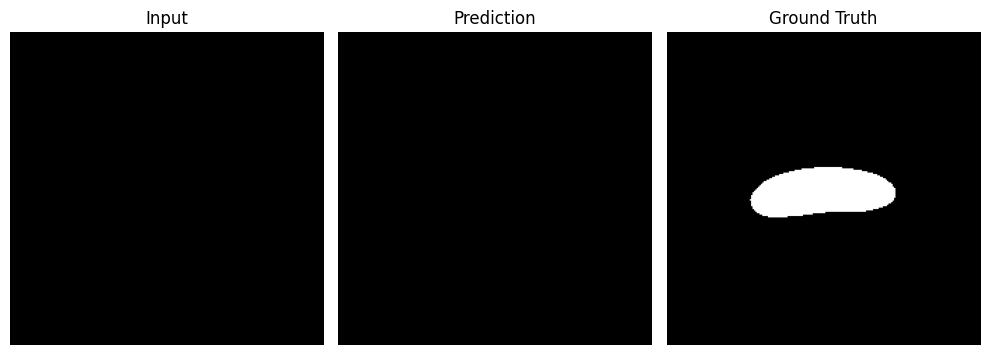

Curren loss : -2


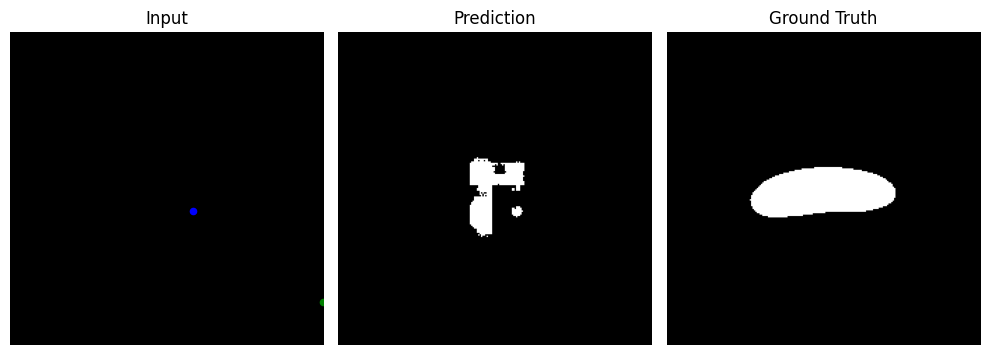

Curren loss : tensor(-0.0529, device='cuda:0')
Episode 1:
  Action Taken: [0.0671014 0.3054875]
  Reward Received: -0.052886124700307846
  Done: False, Truncated: False


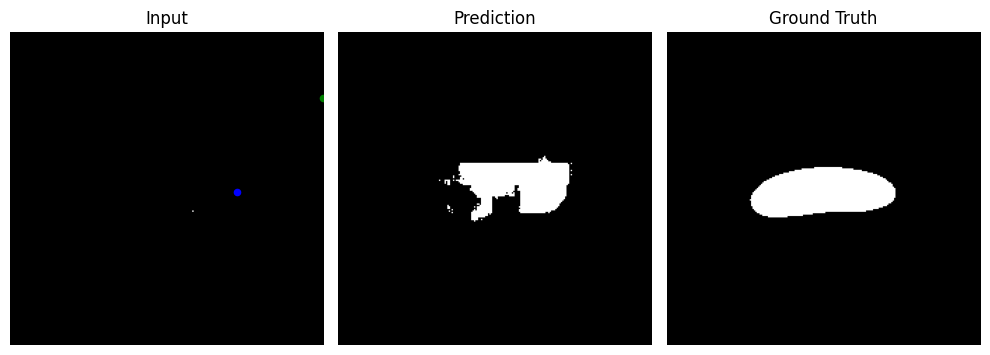

Curren loss : tensor(-0.0888, device='cuda:0')
Episode 1:
  Action Taken: [0.39295498 0.7654524 ]
  Reward Received: -0.0888153538107872
  Done: False, Truncated: False


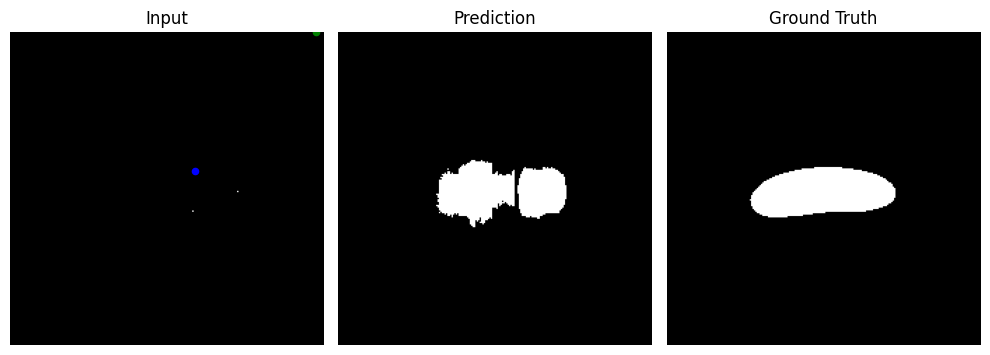

Curren loss : tensor(-0.0990, device='cuda:0')
Episode 1:
  Action Taken: [0.51358616 0.7728706 ]
  Reward Received: -0.09902073442935944
  Done: False, Truncated: False


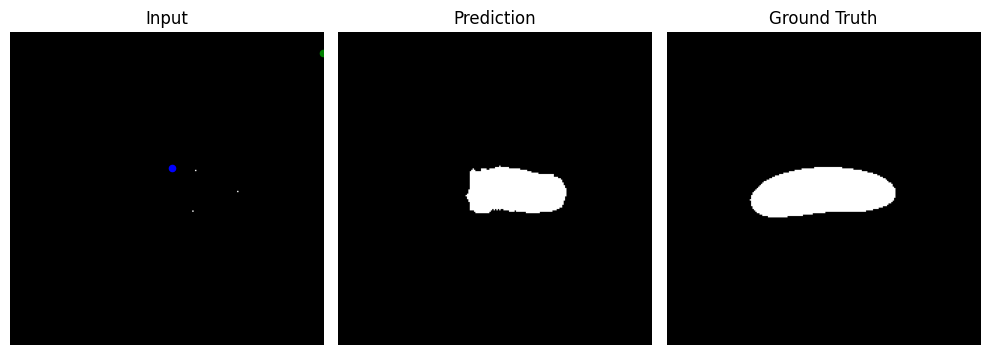

Curren loss : tensor(-0.0801, device='cuda:0')
Episode 1:
  Action Taken: [0.46436673 0.706416  ]
  Reward Received: -0.0800512284040451
  Done: False, Truncated: False


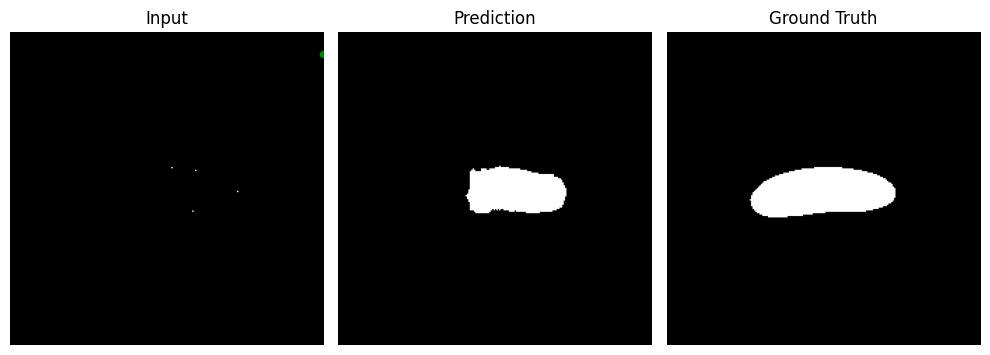

Curren loss : tensor(-0.0801, device='cuda:0')
Episode 1:
  Action Taken: [0.463422   0.84898794]
  Reward Received: -0.0800512284040451
  Done: False, Truncated: False


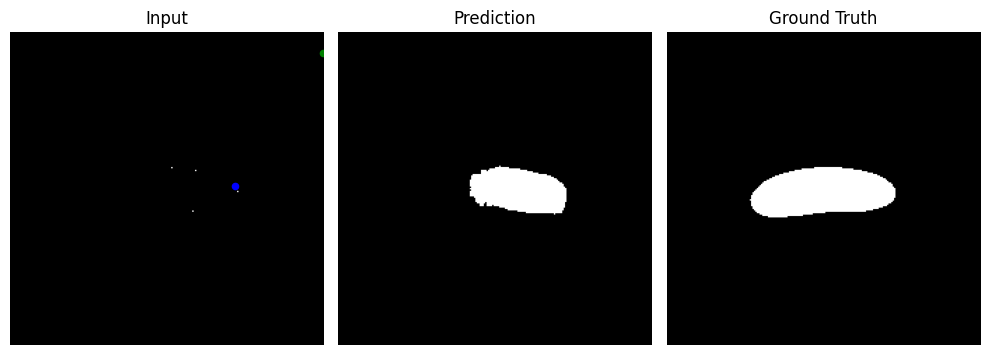

Curren loss : tensor(-0.0779, device='cuda:0')
Episode 1:
  Action Taken: [0.4643098 0.8141334]
  Reward Received: -0.0778978019952774
  Done: False, Truncated: False


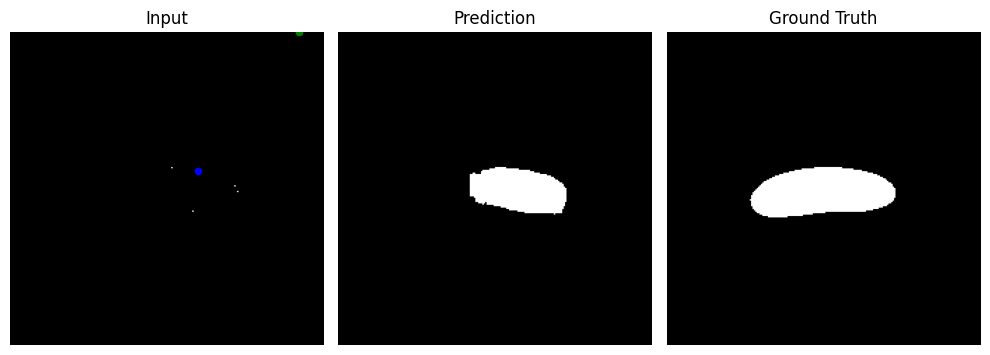

Curren loss : tensor(-0.0842, device='cuda:0')
Episode 1:
  Action Taken: [0.54024315 0.80033237]
  Reward Received: -0.08415718376636505
  Done: False, Truncated: False


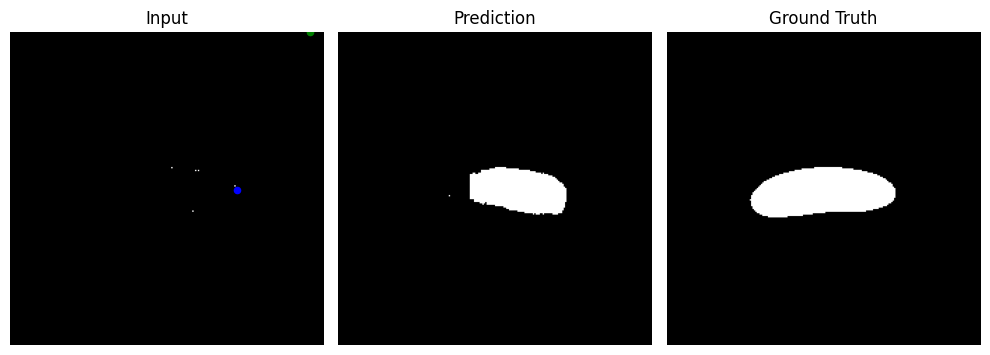

Curren loss : tensor(-0.0890, device='cuda:0')
Episode 1:
  Action Taken: [0.52287006 0.8637912 ]
  Reward Received: -0.08902107924222946
  Done: False, Truncated: False


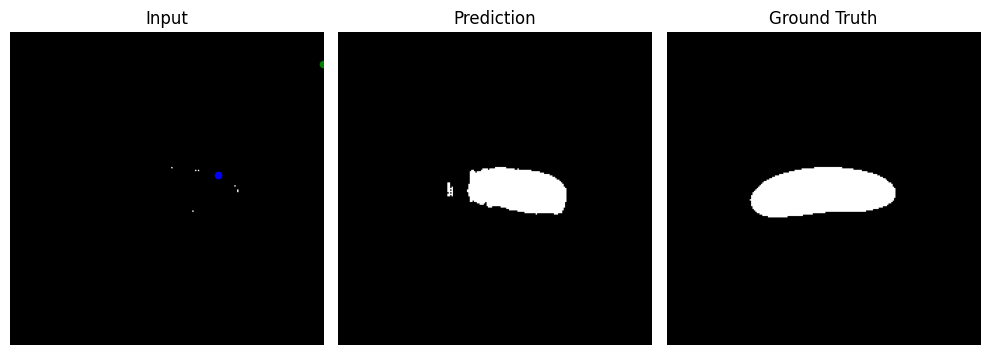

Curren loss : tensor(-0.0940, device='cuda:0')
Episode 1:
  Action Taken: [0.4466154  0.75921434]
  Reward Received: -0.0939672440290451
  Done: False, Truncated: False


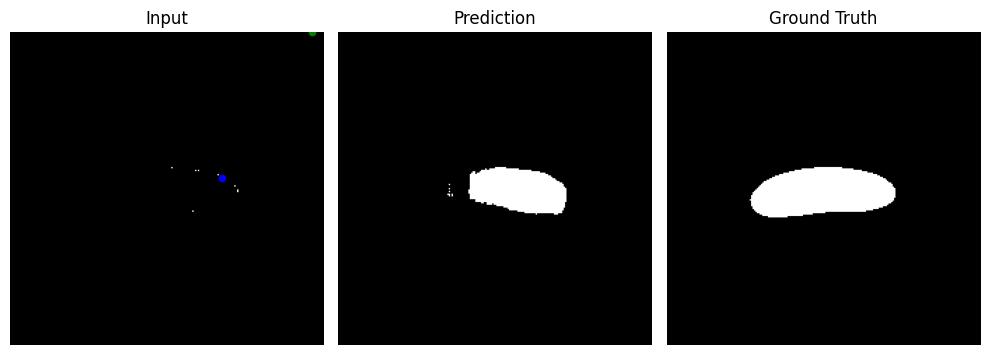

Curren loss : tensor(-0.0949, device='cuda:0')
Episode 1:
  Action Taken: [0.51921874 0.82395244]
  Reward Received: -0.09489472210407257
  Done: False, Truncated: False


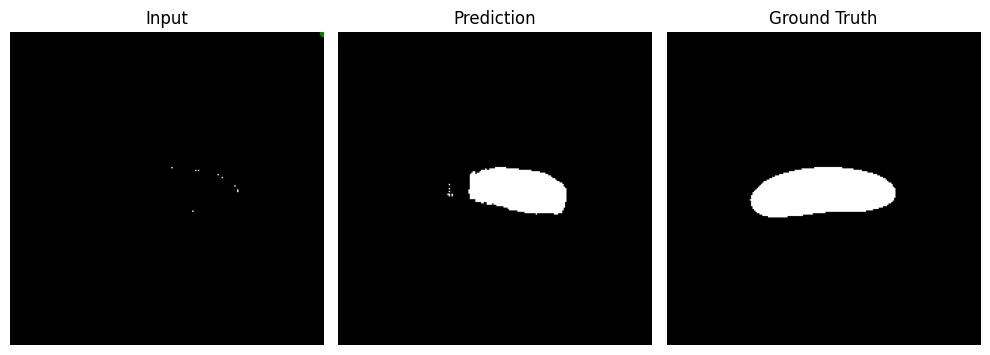

Curren loss : tensor(-0.0949, device='cuda:0')
Episode 1:
  Action Taken: [0.49659455 0.8534709 ]
  Reward Received: -0.09489472210407257
  Done: False, Truncated: False


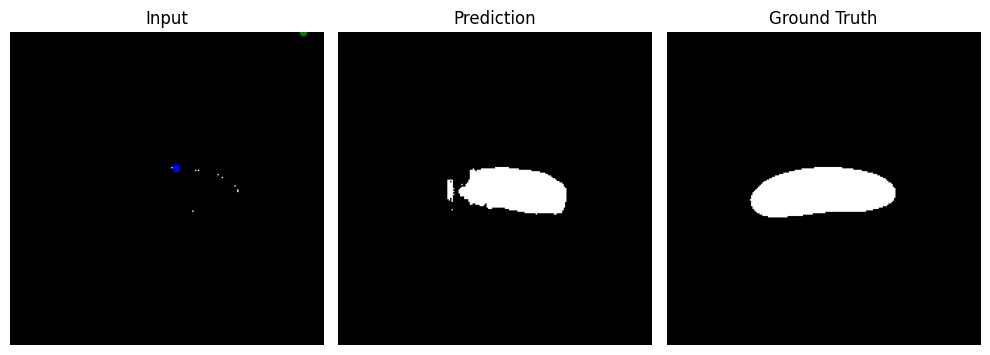

Curren loss : tensor(-0.1026, device='cuda:0')
Episode 1:
  Action Taken: [0.5332898 0.7585548]
  Reward Received: -0.1025681346654892
  Done: False, Truncated: False


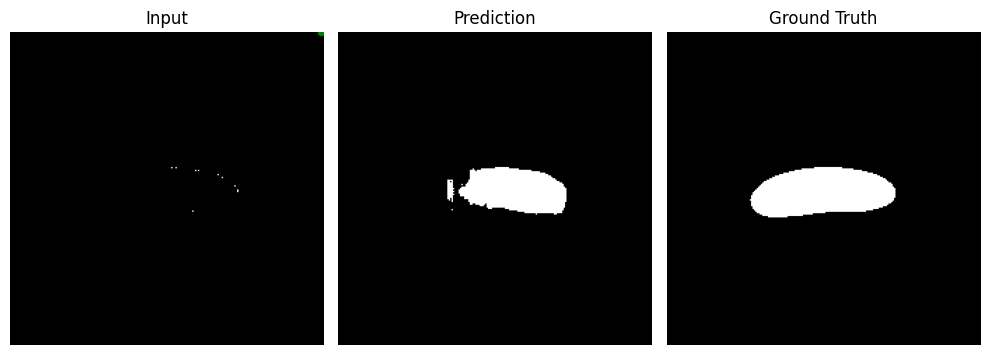

Curren loss : tensor(-0.1026, device='cuda:0')
Episode 1:
  Action Taken: [0.5046751 0.8547538]
  Reward Received: -0.1025681346654892
  Done: False, Truncated: False


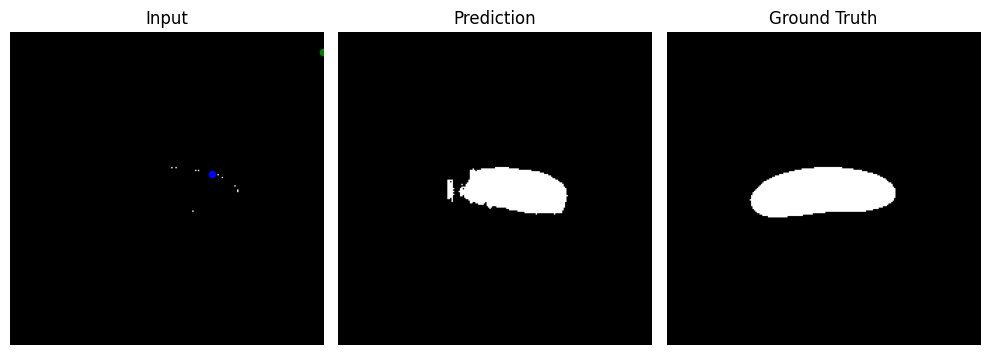

Curren loss : tensor(-0.1059, device='cuda:0')
Episode 1:
  Action Taken: [0.46601015 0.7642891 ]
  Reward Received: -0.10592703521251678
  Done: False, Truncated: False


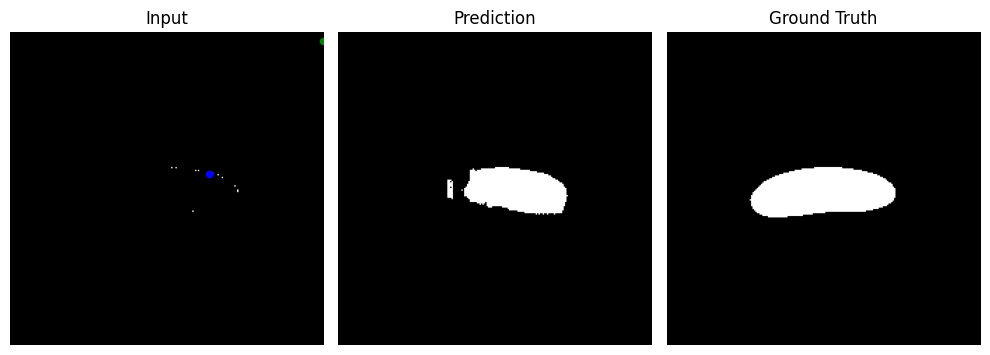

Curren loss : tensor(-0.1068, device='cuda:0')
Episode 1:
  Action Taken: [0.48421243 0.7754029 ]
  Reward Received: -0.10680307447910309
  Done: True, Truncated: False
Episode 1 finished. Resetting environment...


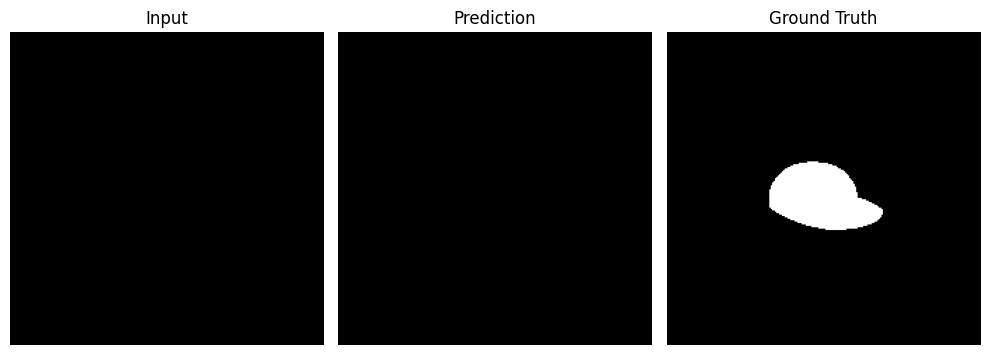

Curren loss : -2


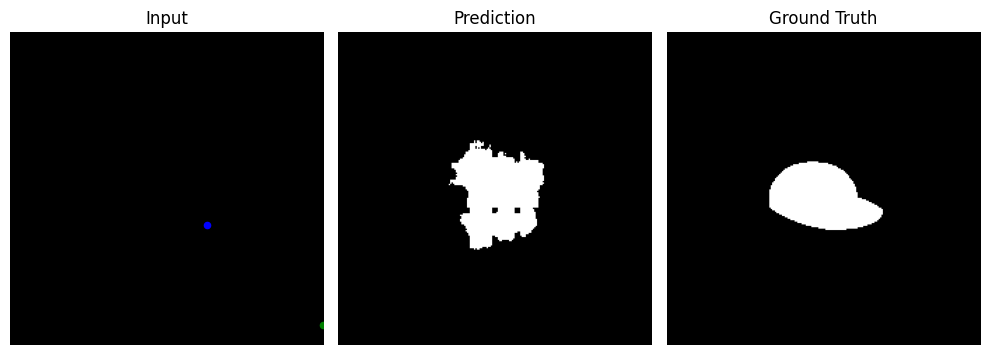

Curren loss : tensor(-0.1093, device='cuda:0')
Episode 2:
  Action Taken: [0.03055575 0.27437255]
  Reward Received: -0.10932715982198715
  Done: False, Truncated: False


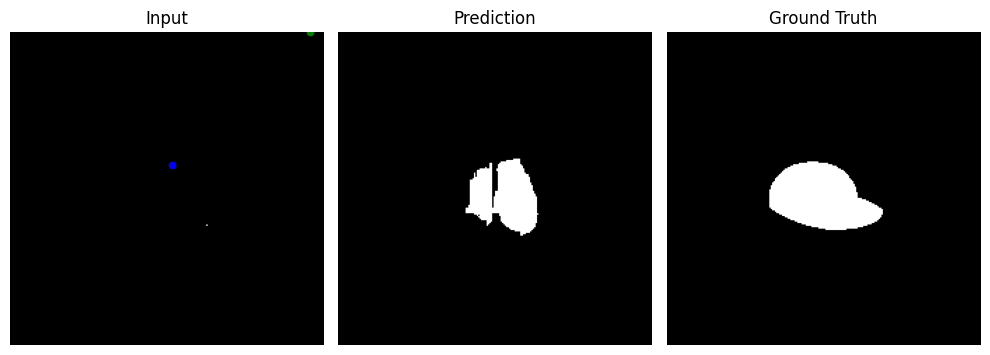

Curren loss : tensor(-0.0783, device='cuda:0')
Episode 2:
  Action Taken: [0.52181   0.7436561]
  Reward Received: -0.07827973365783691
  Done: False, Truncated: False


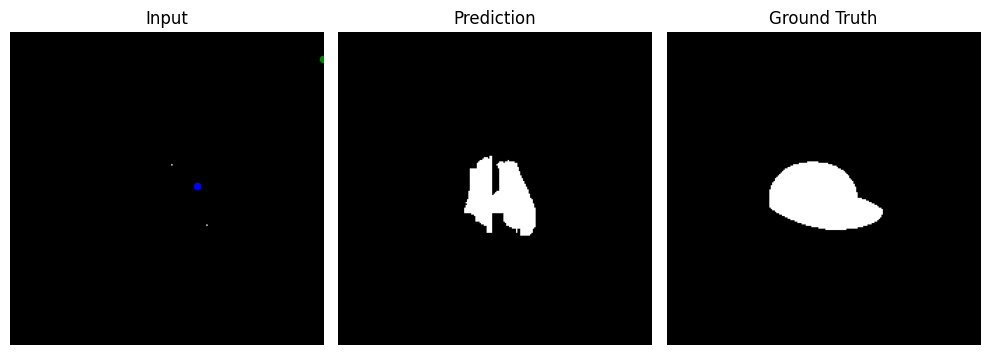

Curren loss : tensor(-0.0738, device='cuda:0')
Episode 2:
  Action Taken: [0.4547568  0.75250536]
  Reward Received: -0.07377563416957855
  Done: False, Truncated: False


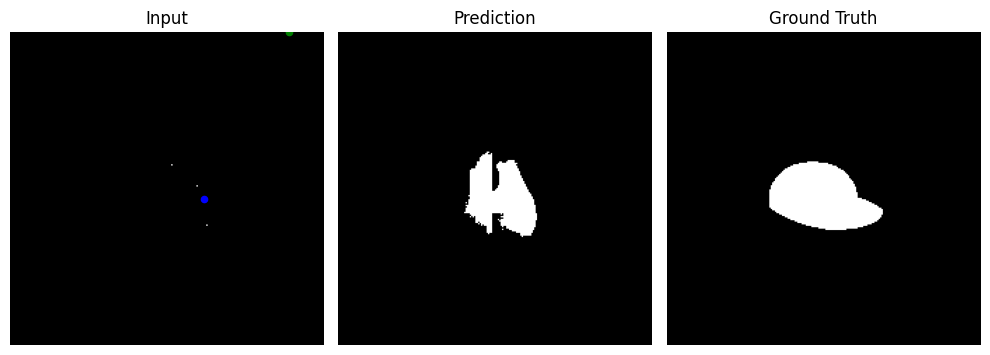

Curren loss : tensor(-0.0801, device='cuda:0')
Episode 2:
  Action Taken: [0.555246  0.8502213]
  Reward Received: -0.08007445186376572
  Done: False, Truncated: False


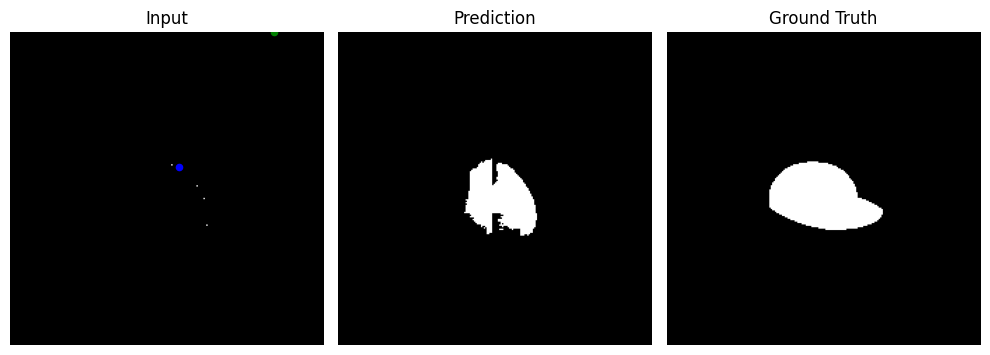

Curren loss : tensor(-0.0765, device='cuda:0')
Episode 2:
  Action Taken: [0.58026105 0.80359185]
  Reward Received: -0.0765475332736969
  Done: False, Truncated: False


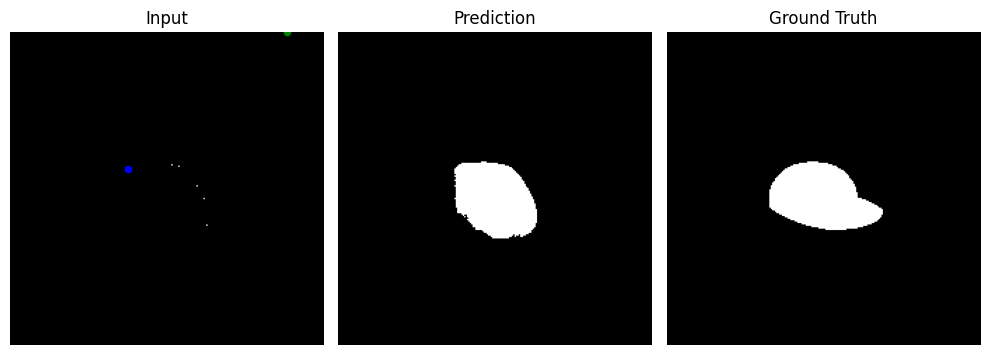

Curren loss : tensor(-0.1153, device='cuda:0')
Episode 2:
  Action Taken: [0.5595281 0.7260743]
  Reward Received: -0.11533640325069427
  Done: False, Truncated: False


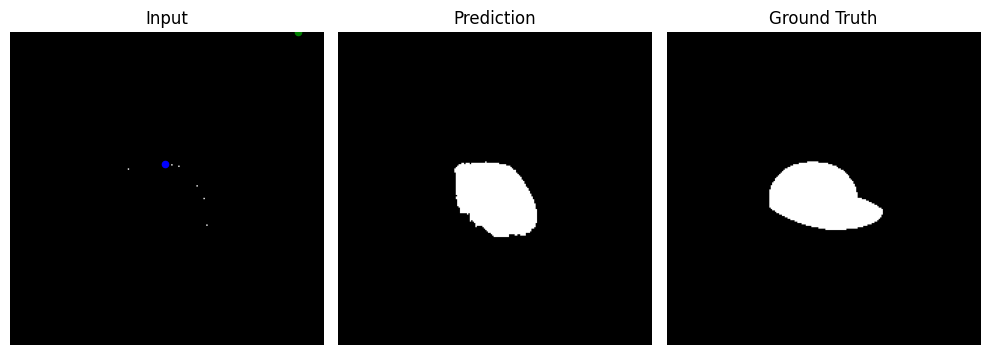

Curren loss : tensor(-0.1088, device='cuda:0')
Episode 2:
  Action Taken: [0.5409651 0.7470401]
  Reward Received: -0.108843132853508
  Done: False, Truncated: False


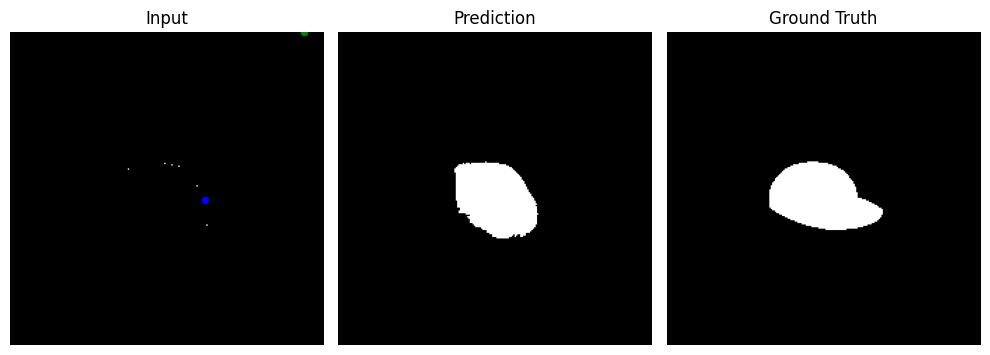

Curren loss : tensor(-0.1145, device='cuda:0')
Episode 2:
  Action Taken: [0.53234285 0.82951856]
  Reward Received: -0.11454445868730545
  Done: False, Truncated: False


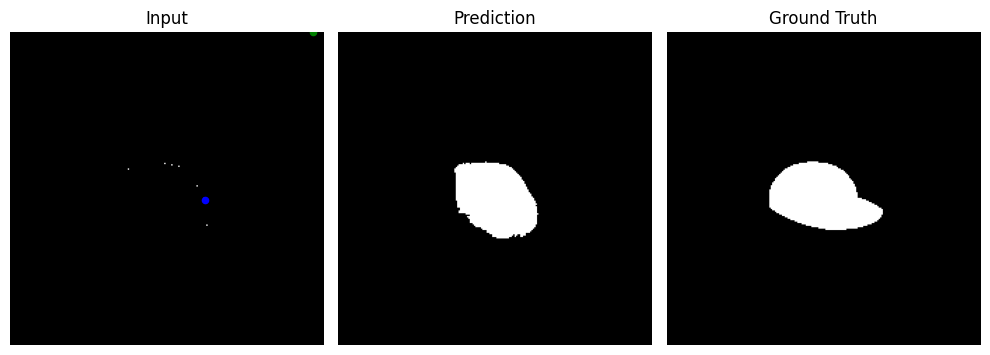

Curren loss : tensor(-0.1145, device='cuda:0')
Episode 2:
  Action Taken: [0.518077  0.8180856]
  Reward Received: -0.11454445868730545
  Done: False, Truncated: False


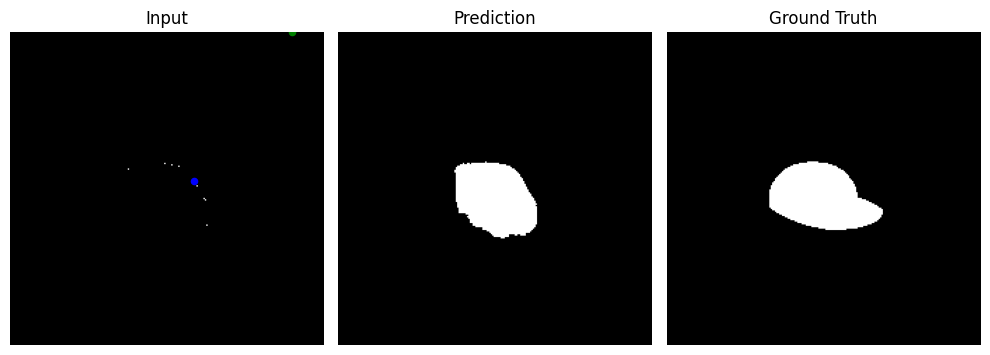

Curren loss : tensor(-0.1188, device='cuda:0')
Episode 2:
  Action Taken: [0.5511789 0.8129738]
  Reward Received: -0.1188073456287384
  Done: False, Truncated: False


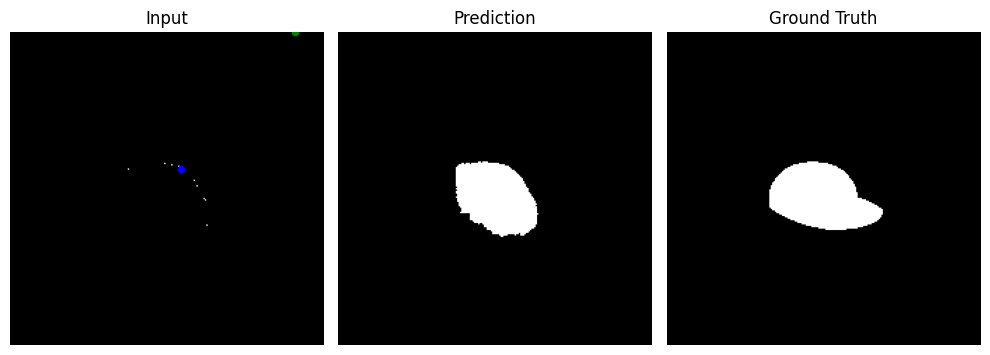

Curren loss : tensor(-0.1138, device='cuda:0')
Episode 2:
  Action Taken: [0.54640335 0.77931863]
  Reward Received: -0.11383727937936783
  Done: False, Truncated: False


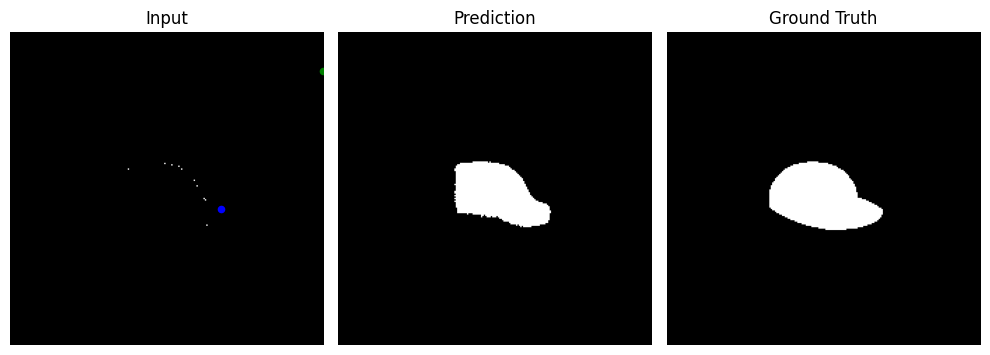

Curren loss : tensor(-0.0875, device='cuda:0')
Episode 2:
  Action Taken: [0.43622732 0.7971401 ]
  Reward Received: -0.08747514337301254
  Done: False, Truncated: False


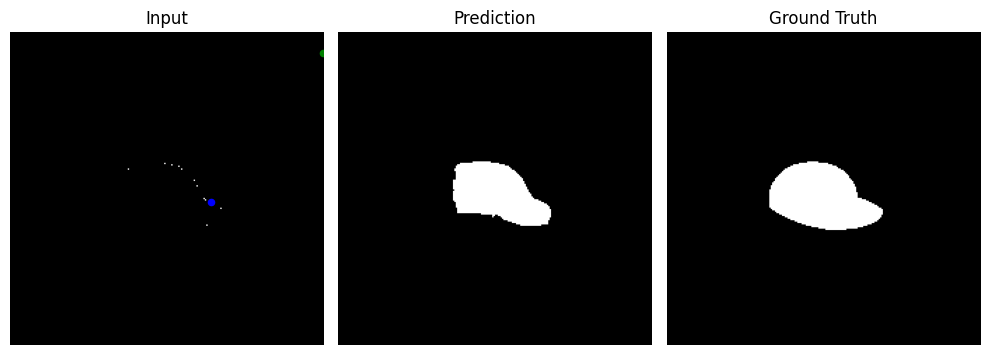

Curren loss : tensor(-0.0893, device='cuda:0')
Episode 2:
  Action Taken: [0.46486896 0.79528964]
  Reward Received: -0.08931966871023178
  Done: False, Truncated: False


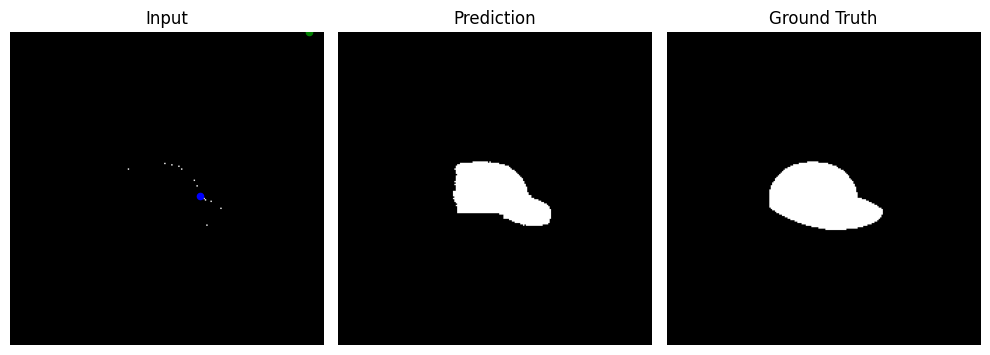

Curren loss : tensor(-0.0816, device='cuda:0')
Episode 2:
  Action Taken: [0.5247418 0.8129041]
  Reward Received: -0.08163122832775116
  Done: False, Truncated: False


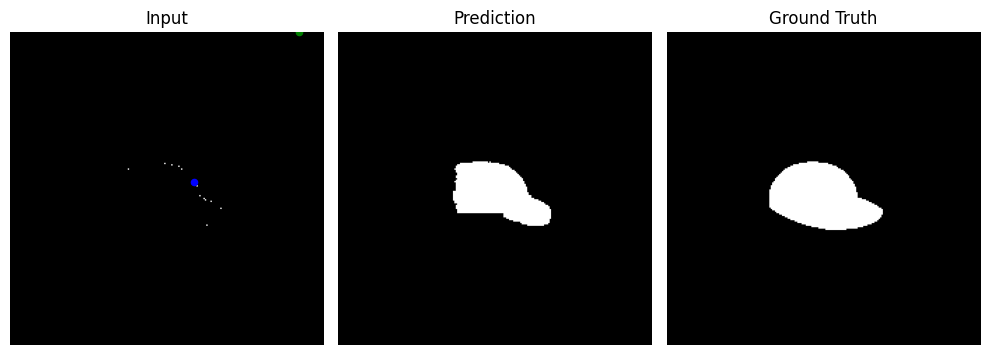

Curren loss : tensor(-0.0798, device='cuda:0')
Episode 2:
  Action Taken: [0.54072106 0.8057077 ]
  Reward Received: -0.07976280897855759
  Done: True, Truncated: False
Episode 2 finished. Resetting environment...


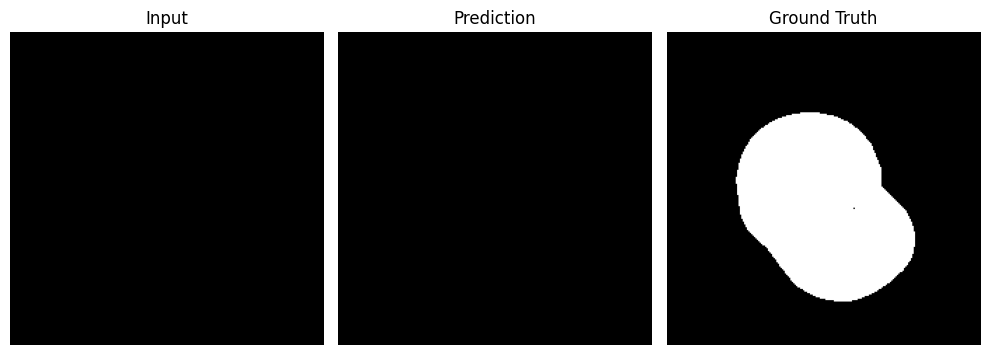

Curren loss : -2


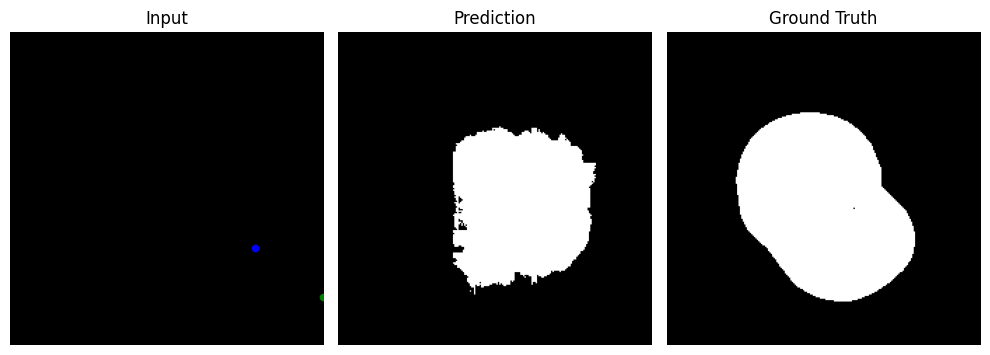

Curren loss : tensor(-0.3042, device='cuda:0')
Episode 3:
  Action Taken: [0.07478868 0.29630846]
  Reward Received: -0.3041643798351288
  Done: False, Truncated: False


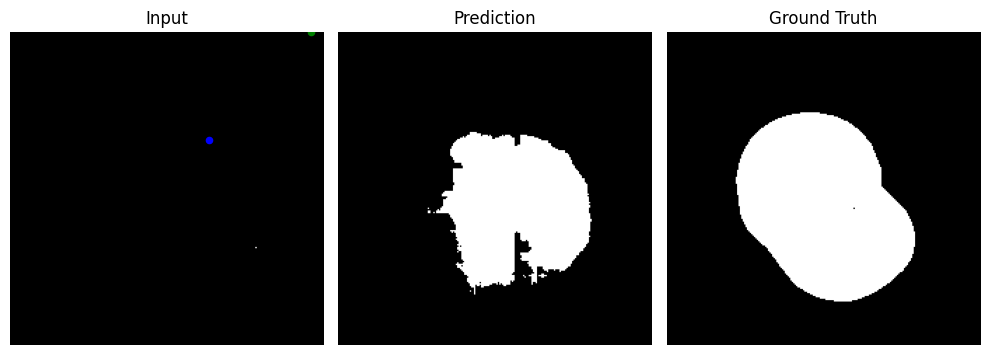

Curren loss : tensor(-0.2811, device='cuda:0')
Episode 3:
  Action Taken: [0.5207289 0.7591364]
  Reward Received: -0.28106796741485596
  Done: False, Truncated: False


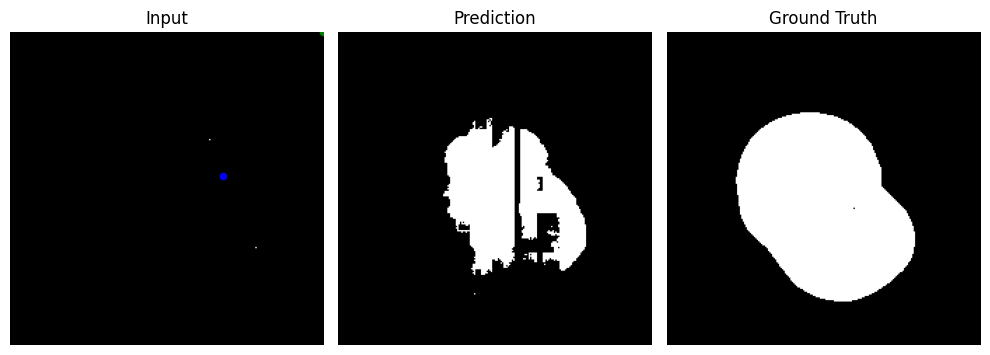

Curren loss : tensor(-0.1963, device='cuda:0')
Episode 3:
  Action Taken: [0.49806812 0.8089555 ]
  Reward Received: -0.1963454931974411
  Done: False, Truncated: False


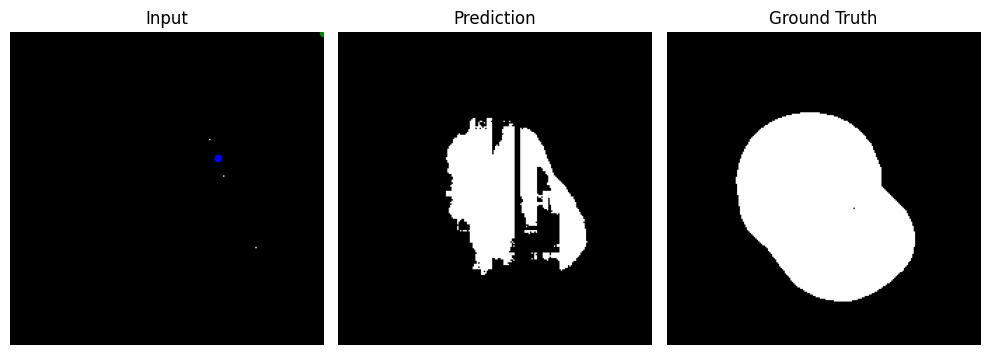

Curren loss : tensor(-0.1809, device='cuda:0')
Episode 3:
  Action Taken: [0.49725494 0.7794973 ]
  Reward Received: -0.18087026476860046
  Done: False, Truncated: False


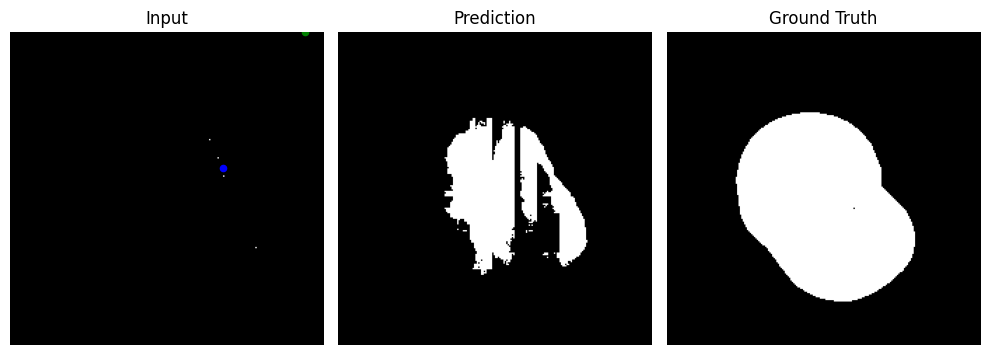

Curren loss : tensor(-0.1747, device='cuda:0')
Episode 3:
  Action Taken: [0.5303331  0.82866836]
  Reward Received: -0.1746852844953537
  Done: False, Truncated: False


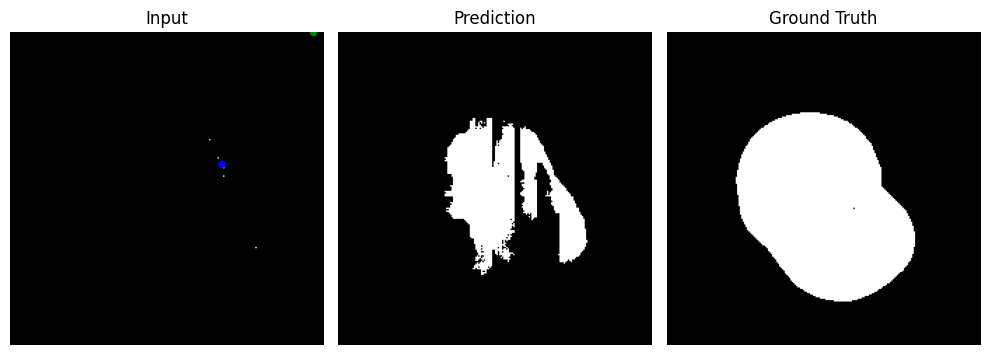

Curren loss : tensor(-0.1661, device='cuda:0')
Episode 3:
  Action Taken: [0.5176863  0.80636966]
  Reward Received: -0.1661216914653778
  Done: False, Truncated: False


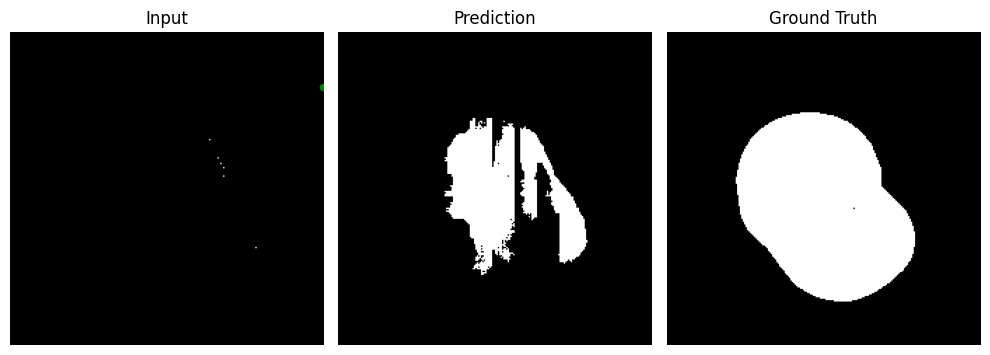

Curren loss : tensor(-0.1661, device='cuda:0')
Episode 3:
  Action Taken: [0.40996093 0.8808536 ]
  Reward Received: -0.1661216914653778
  Done: False, Truncated: False


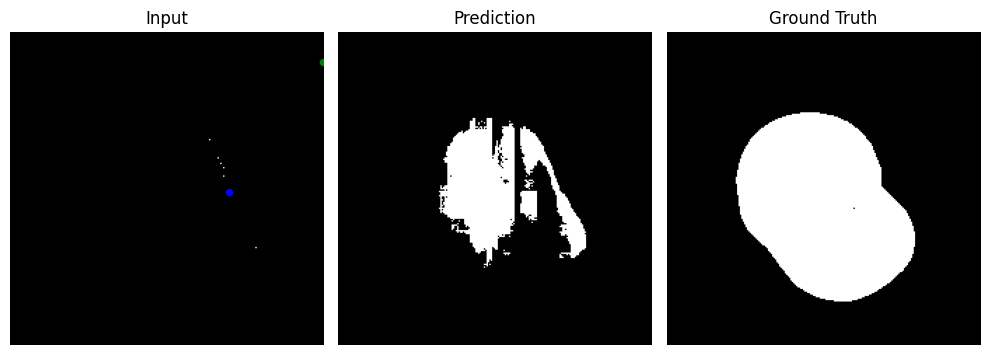

Curren loss : tensor(-0.1534, device='cuda:0')
Episode 3:
  Action Taken: [0.45109573 0.8022114 ]
  Reward Received: -0.15343591570854187
  Done: False, Truncated: False


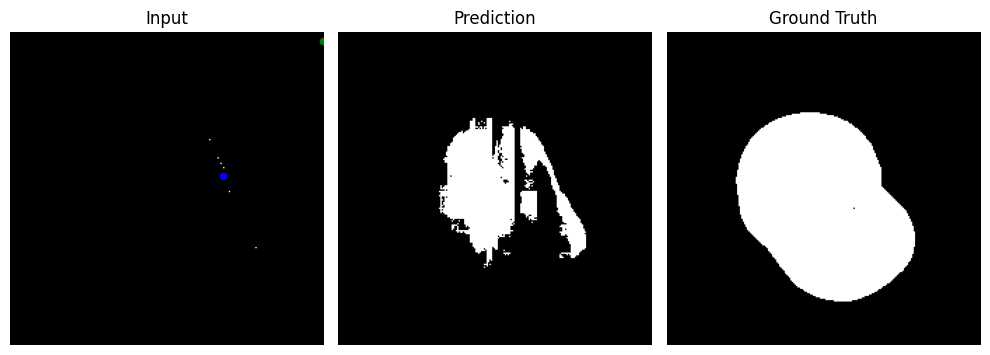

Curren loss : tensor(-0.1534, device='cuda:0')
Episode 3:
  Action Taken: [0.48447925 0.7989724 ]
  Reward Received: -0.15343591570854187
  Done: False, Truncated: False


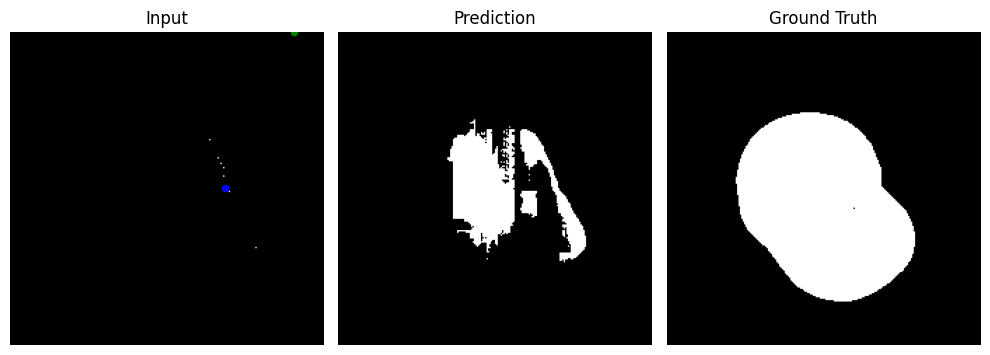

Curren loss : tensor(-0.1362, device='cuda:0')
Episode 3:
  Action Taken: [0.5474966 0.8666596]
  Reward Received: -0.13618376851081848
  Done: False, Truncated: False


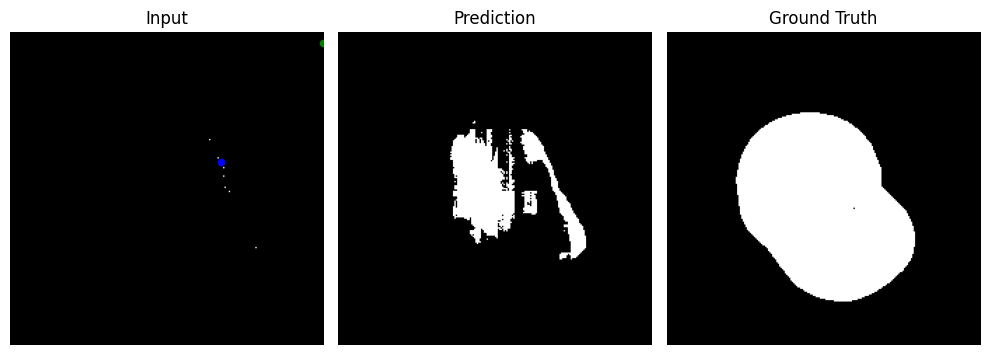

Curren loss : tensor(-0.1218, device='cuda:0')
Episode 3:
  Action Taken: [0.48008525 0.77394897]
  Reward Received: -0.12178386002779007
  Done: False, Truncated: False


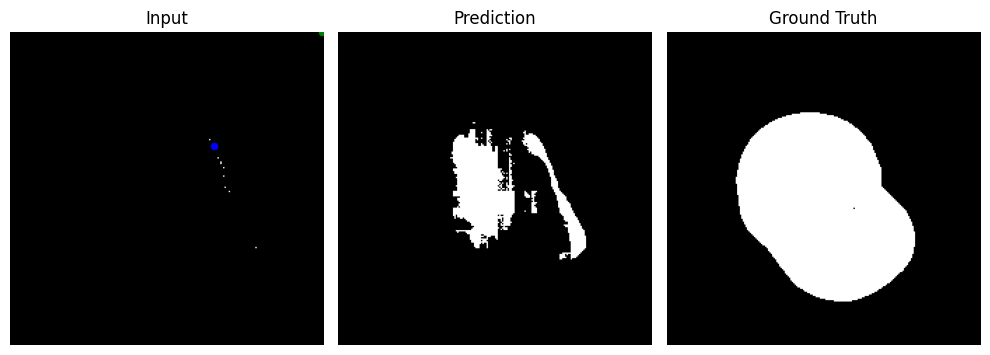

Curren loss : tensor(-0.1154, device='cuda:0')
Episode 3:
  Action Taken: [0.5031872 0.7566455]
  Reward Received: -0.11539143323898315
  Done: False, Truncated: False


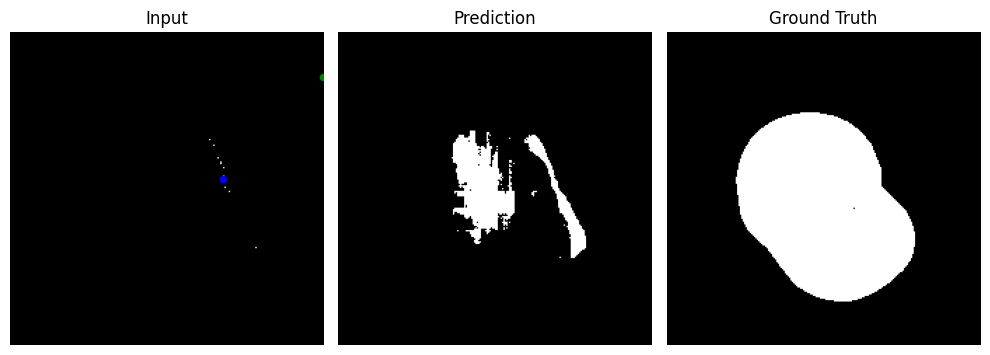

Curren loss : tensor(-0.1028, device='cuda:0')
Episode 3:
  Action Taken: [0.42631572 0.75576884]
  Reward Received: -0.10276854783296585
  Done: False, Truncated: False


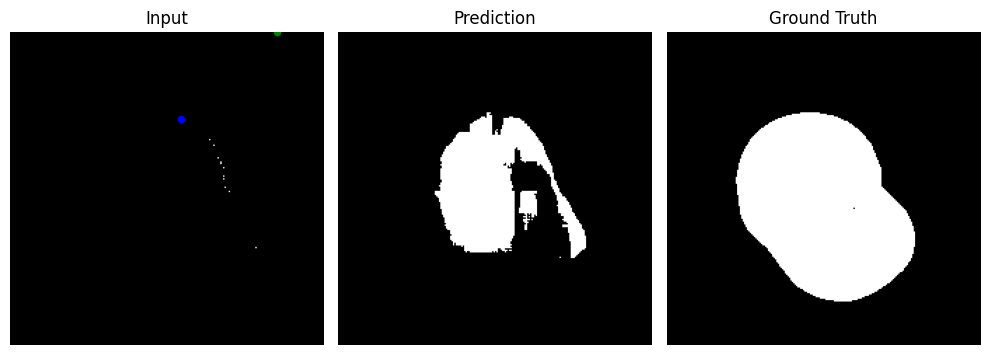

Curren loss : tensor(-0.1896, device='cuda:0')
Episode 3:
  Action Taken: [0.5744559 0.7335136]
  Reward Received: -0.1896258294582367
  Done: False, Truncated: False


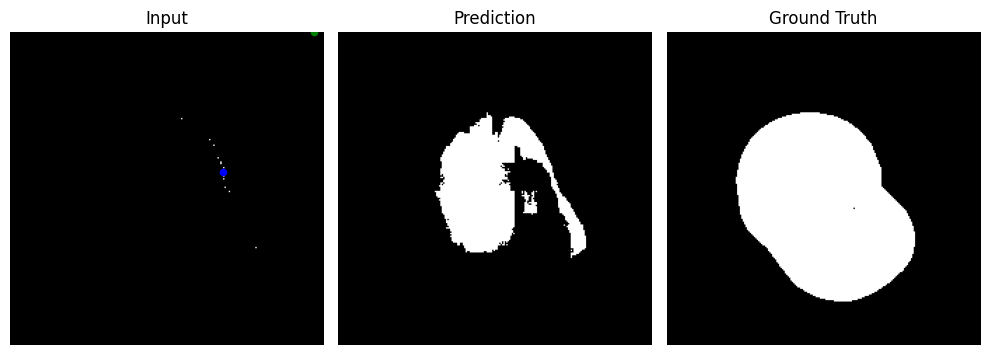

Curren loss : tensor(-0.1714, device='cuda:0')
Episode 3:
  Action Taken: [0.5153827 0.8173075]
  Reward Received: -0.17142091691493988
  Done: True, Truncated: False
Episode 3 finished. Resetting environment...


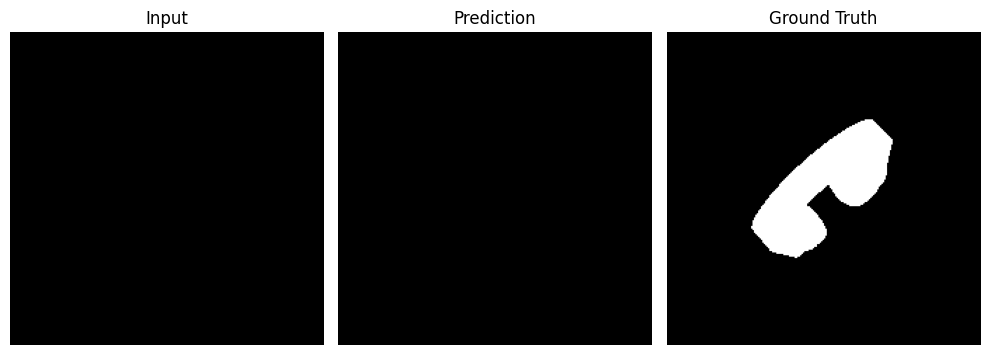

Curren loss : -2


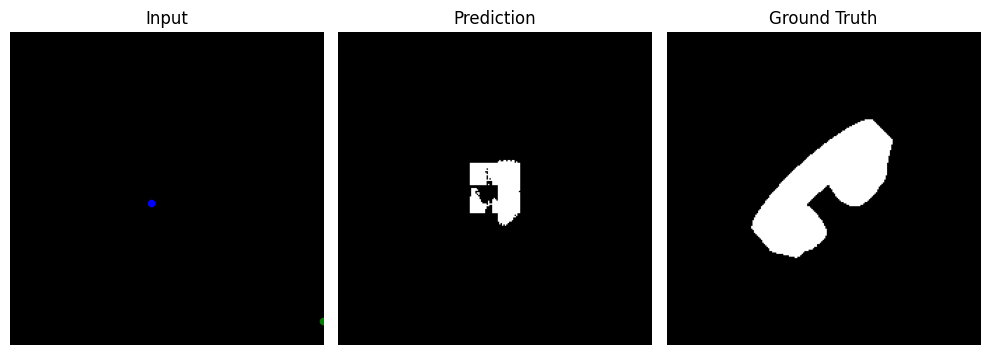

Curren loss : tensor(-0.0476, device='cuda:0')
Episode 4:
  Action Taken: [0.03646623 0.3073262 ]
  Reward Received: -0.04757470265030861
  Done: False, Truncated: False


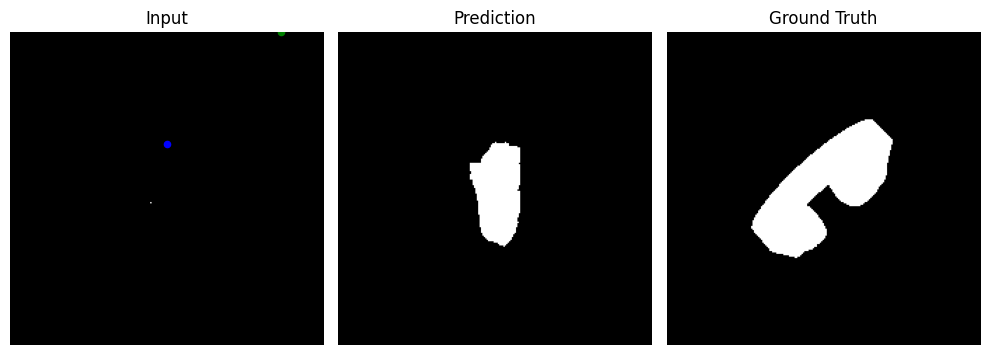

Curren loss : tensor(-0.0729, device='cuda:0')
Episode 4:
  Action Taken: [0.56940264 0.7483065 ]
  Reward Received: -0.07285943627357483
  Done: False, Truncated: False


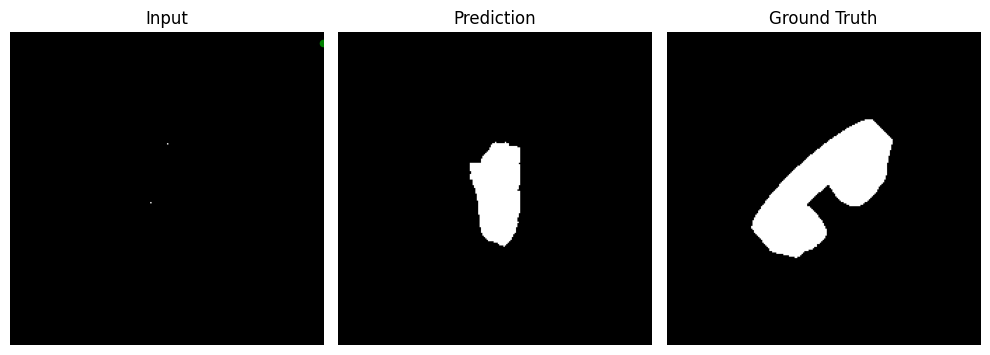

Curren loss : tensor(-0.0729, device='cuda:0')
Episode 4:
  Action Taken: [0.48068538 0.8348717 ]
  Reward Received: -0.07285943627357483
  Done: False, Truncated: False


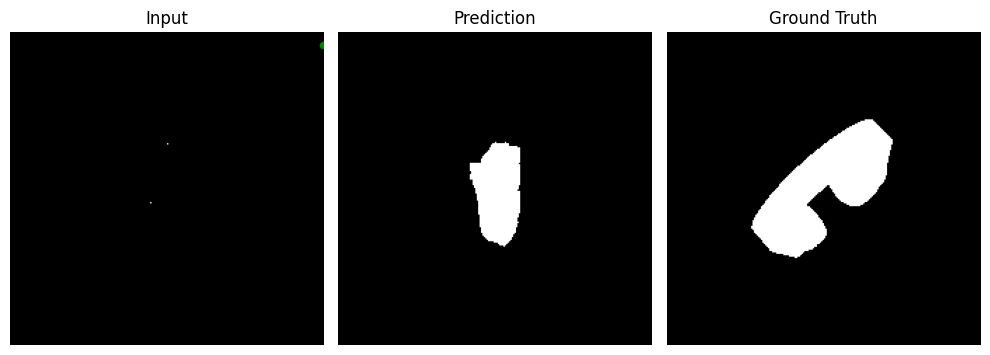

Curren loss : tensor(-0.0729, device='cuda:0')
Episode 4:
  Action Taken: [0.4771471 0.8077965]
  Reward Received: -0.07285943627357483
  Done: False, Truncated: False


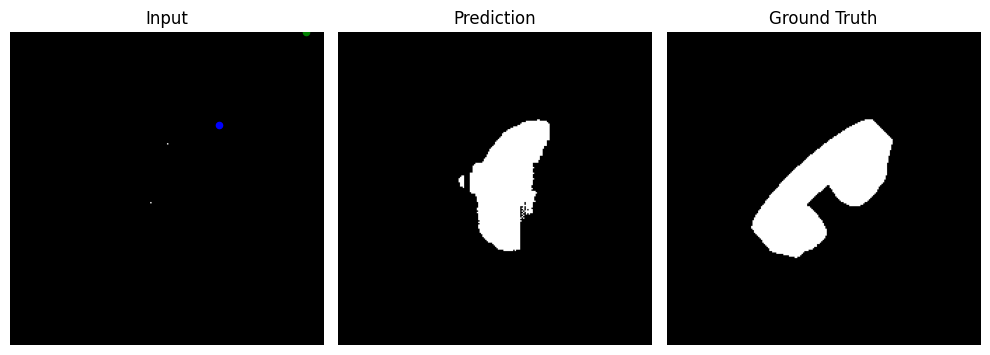

Curren loss : tensor(-0.1460, device='cuda:0')
Episode 4:
  Action Taken: [0.5280794  0.76065964]
  Reward Received: -0.14595167338848114
  Done: False, Truncated: False


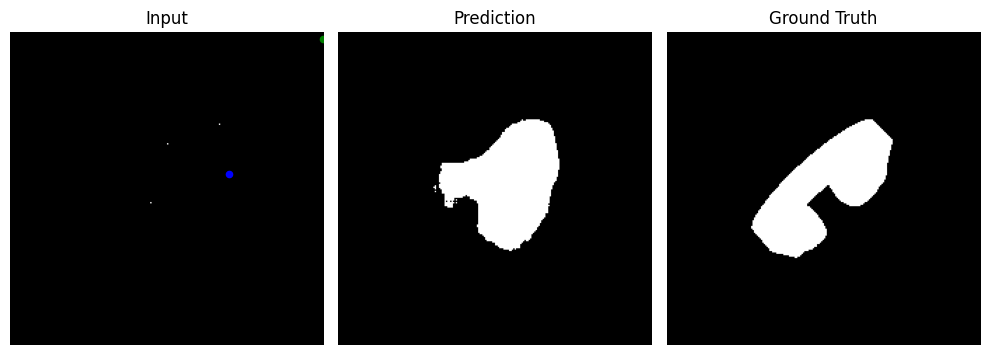

Curren loss : tensor(-0.2241, device='cuda:0')
Episode 4:
  Action Taken: [0.48739254 0.8068081 ]
  Reward Received: -0.22412681579589844
  Done: False, Truncated: False


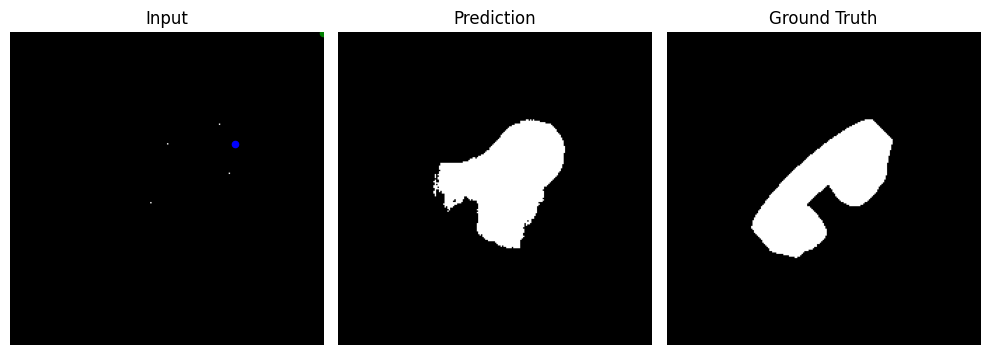

Curren loss : tensor(-0.2048, device='cuda:0')
Episode 4:
  Action Taken: [0.4969966  0.78751266]
  Reward Received: -0.2047538459300995
  Done: False, Truncated: False


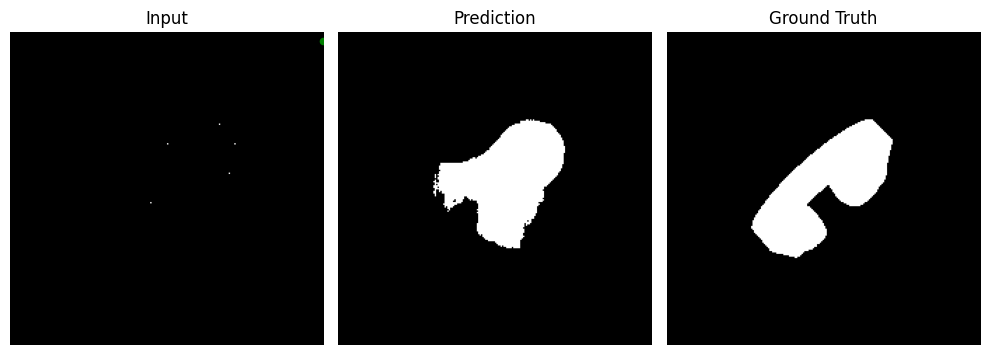

Curren loss : tensor(-0.2048, device='cuda:0')
Episode 4:
  Action Taken: [0.48464963 0.8279819 ]
  Reward Received: -0.2047538459300995
  Done: False, Truncated: False


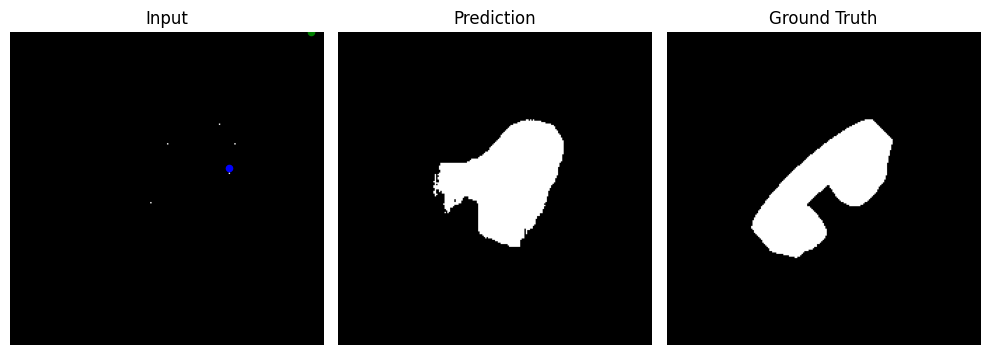

Curren loss : tensor(-0.2114, device='cuda:0')
Episode 4:
  Action Taken: [0.5205658 0.8262971]
  Reward Received: -0.21138054132461548
  Done: False, Truncated: False


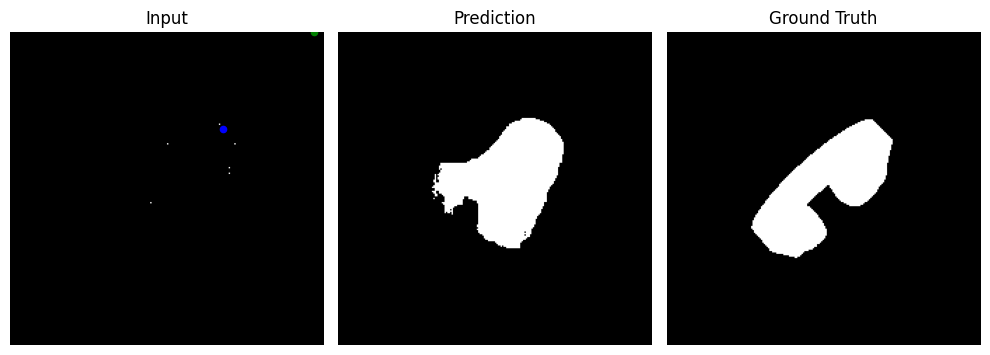

Curren loss : tensor(-0.2123, device='cuda:0')
Episode 4:
  Action Taken: [0.5154147  0.75937426]
  Reward Received: -0.21227985620498657
  Done: False, Truncated: False


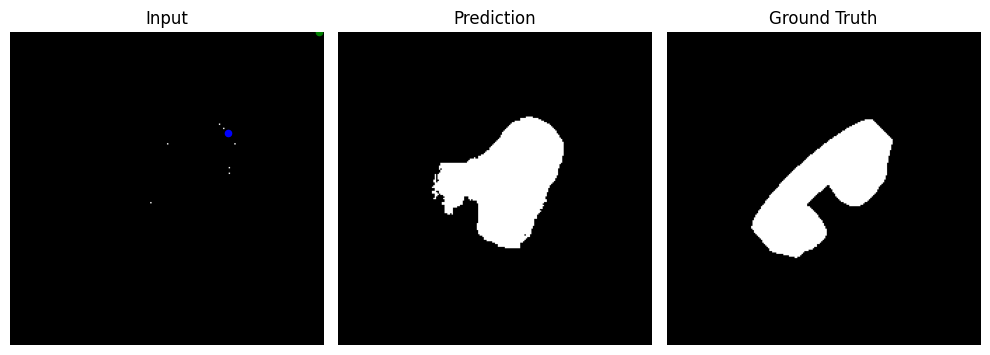

Curren loss : tensor(-0.2136, device='cuda:0')
Episode 4:
  Action Taken: [0.50739497 0.76466316]
  Reward Received: -0.21363571286201477
  Done: False, Truncated: False


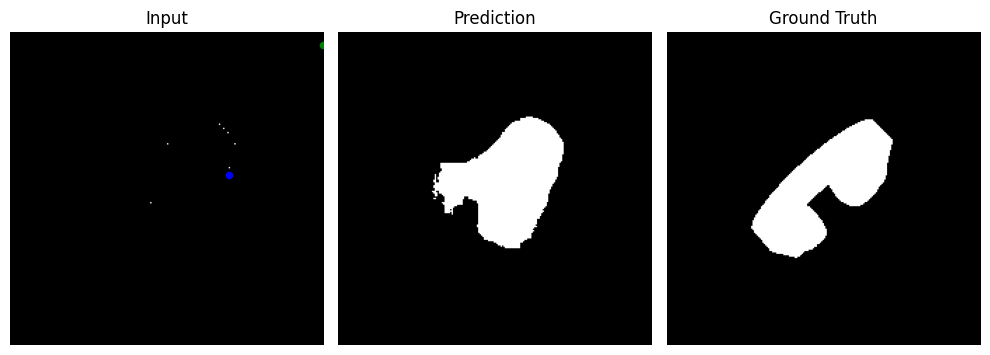

Curren loss : tensor(-0.2214, device='cuda:0')
Episode 4:
  Action Taken: [0.47826818 0.8020411 ]
  Reward Received: -0.2214091569185257
  Done: False, Truncated: False


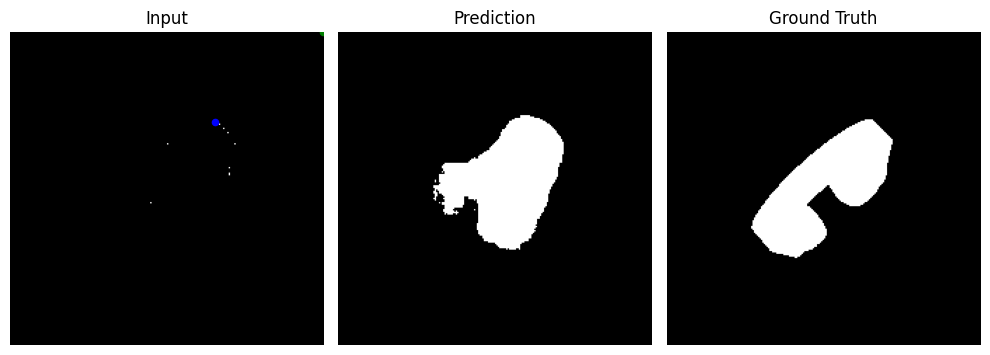

Curren loss : tensor(-0.2268, device='cuda:0')
Episode 4:
  Action Taken: [0.50159514 0.72129786]
  Reward Received: -0.2268069088459015
  Done: False, Truncated: False


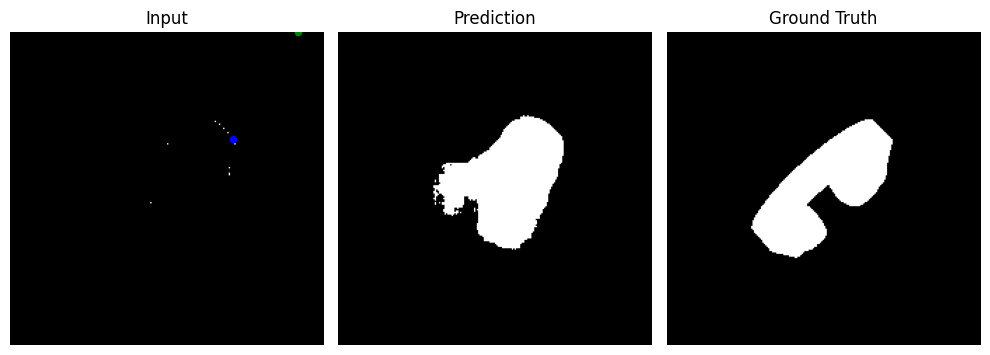

Curren loss : tensor(-0.2215, device='cuda:0')
Episode 4:
  Action Taken: [0.541715  0.8262008]
  Reward Received: -0.2214662879705429
  Done: False, Truncated: False


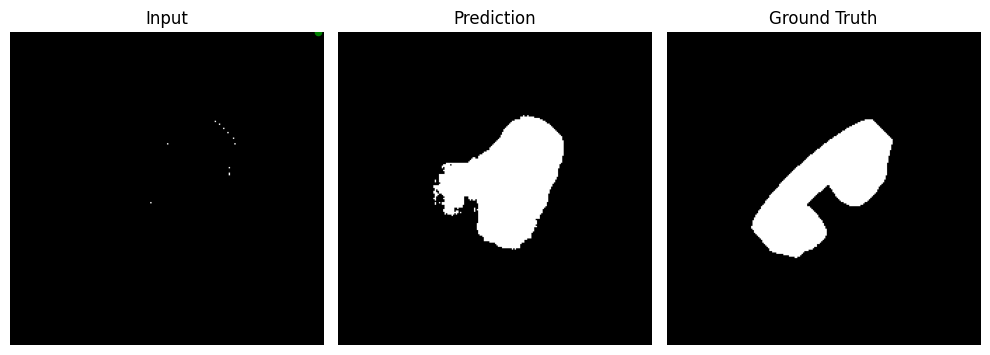

Curren loss : tensor(-0.2215, device='cuda:0')
Episode 4:
  Action Taken: [0.5091738 0.8487144]
  Reward Received: -0.2214662879705429
  Done: True, Truncated: False
Episode 4 finished. Resetting environment...


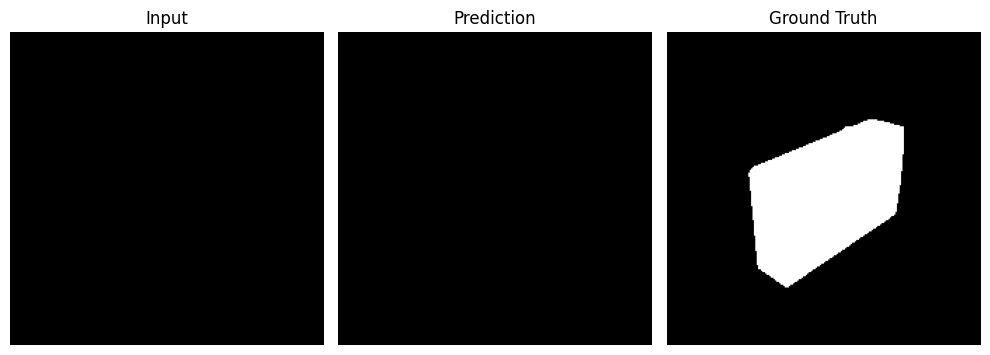

Curren loss : -2


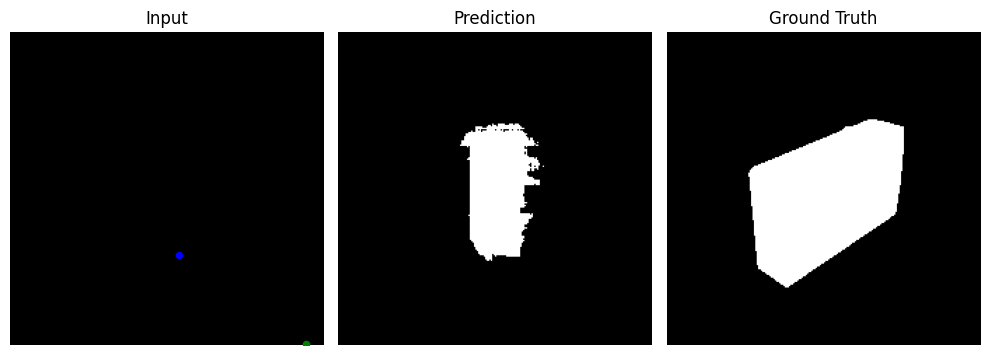

Curren loss : tensor(-0.1400, device='cuda:0')
Episode 5:
  Action Taken: [-0.02930817  0.3031891 ]
  Reward Received: -0.1400470733642578
  Done: False, Truncated: False


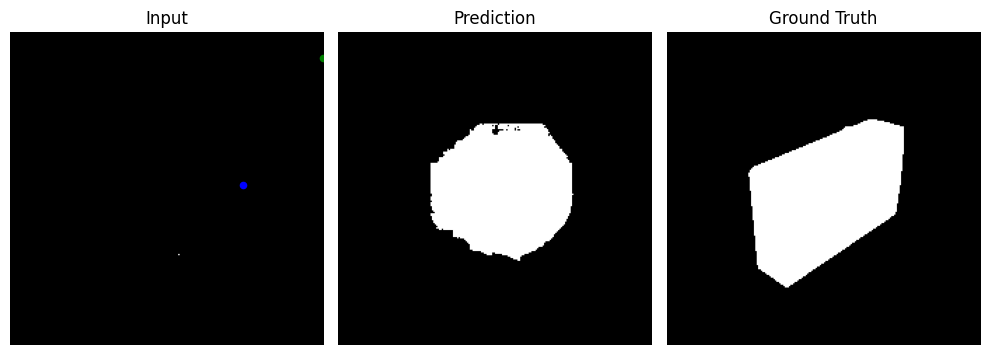

Curren loss : tensor(-0.2698, device='cuda:0')
Episode 5:
  Action Taken: [0.4574177 0.8224995]
  Reward Received: -0.2698482275009155
  Done: False, Truncated: False


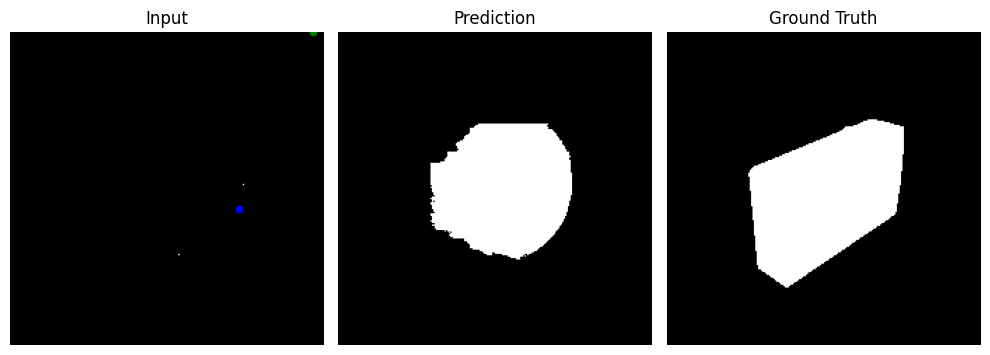

Curren loss : tensor(-0.3262, device='cuda:0')
Episode 5:
  Action Taken: [0.5176844 0.8742463]
  Reward Received: -0.32618221640586853
  Done: False, Truncated: False


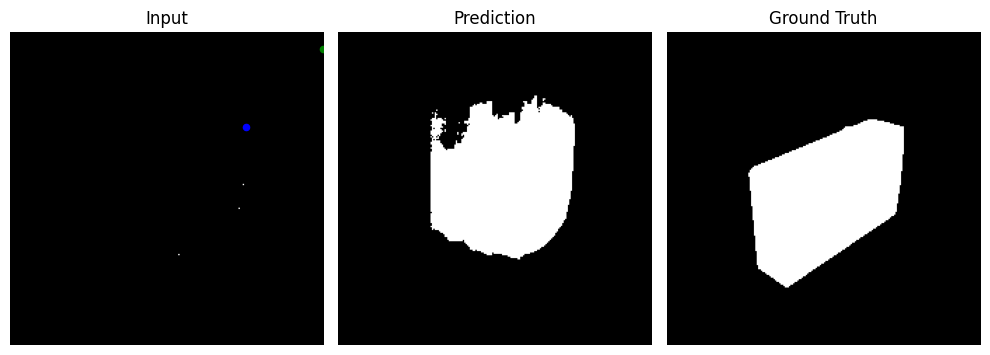

Curren loss : tensor(-0.5045, device='cuda:0')
Episode 5:
  Action Taken: [0.470753   0.75152826]
  Reward Received: -0.5044854879379272
  Done: False, Truncated: False


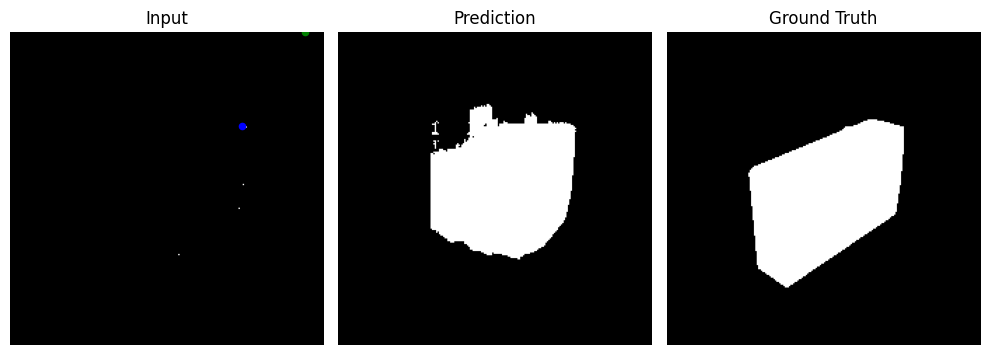

Curren loss : tensor(-0.4435, device='cuda:0')
Episode 5:
  Action Taken: [0.52982014 0.8117973 ]
  Reward Received: -0.44349101185798645
  Done: False, Truncated: False


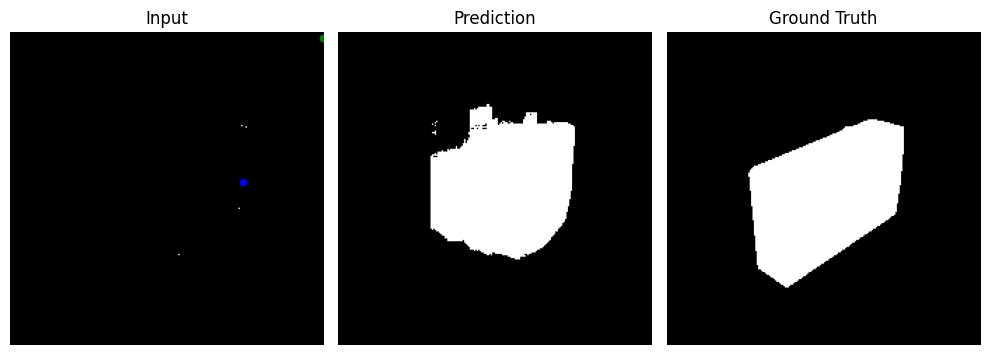

Curren loss : tensor(-0.4906, device='cuda:0')
Episode 5:
  Action Taken: [0.4880042 0.839482 ]
  Reward Received: -0.490599125623703
  Done: False, Truncated: False


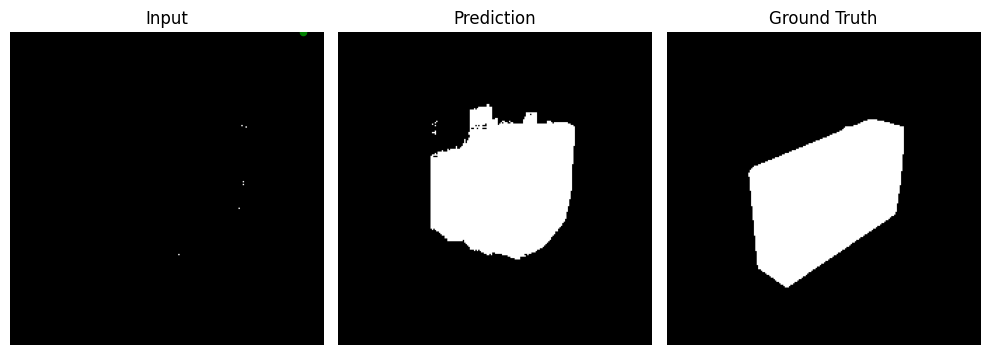

Curren loss : tensor(-0.4906, device='cuda:0')
Episode 5:
  Action Taken: [0.534167   0.90351135]
  Reward Received: -0.490599125623703
  Done: False, Truncated: False


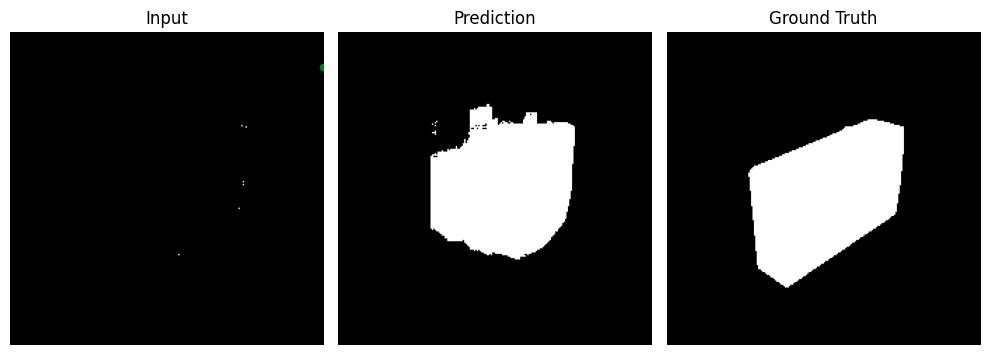

Curren loss : tensor(-0.4906, device='cuda:0')
Episode 5:
  Action Taken: [0.4425995 0.8428942]
  Reward Received: -0.490599125623703
  Done: False, Truncated: False


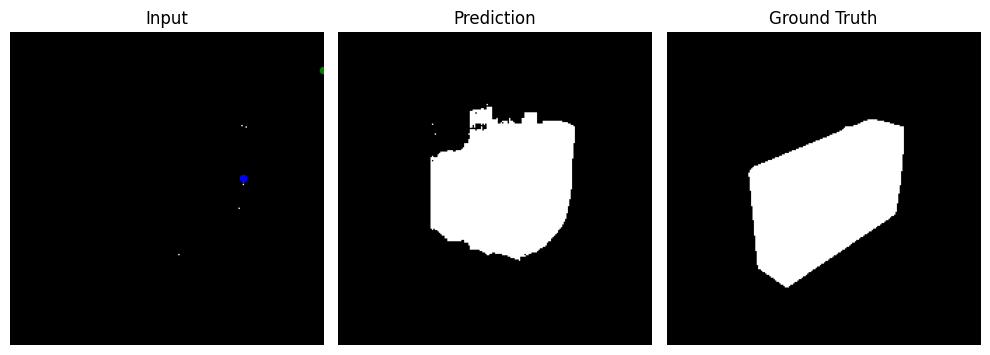

Curren loss : tensor(-0.5227, device='cuda:0')
Episode 5:
  Action Taken: [0.43735313 0.79737884]
  Reward Received: -0.5227277874946594
  Done: False, Truncated: False


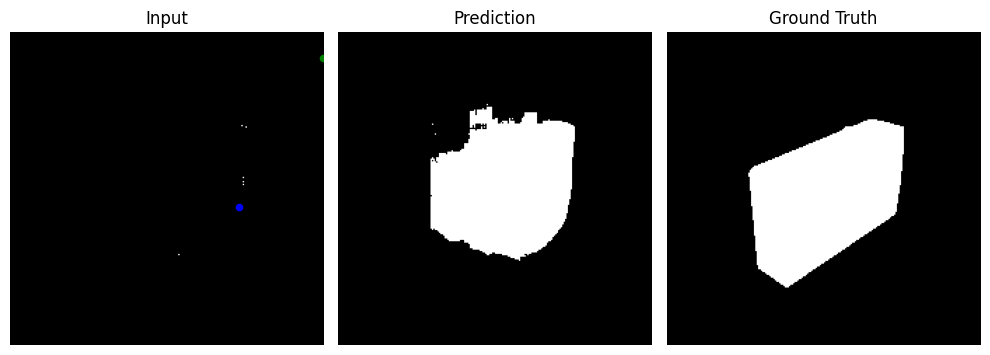

Curren loss : tensor(-0.5255, device='cuda:0')
Episode 5:
  Action Taken: [0.45637184 0.8377281 ]
  Reward Received: -0.5254766941070557
  Done: False, Truncated: False


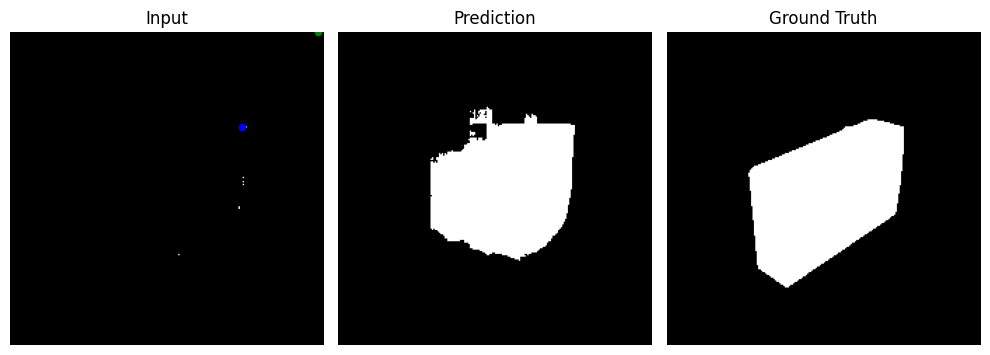

Curren loss : tensor(-0.4840, device='cuda:0')
Episode 5:
  Action Taken: [0.51007867 0.78473705]
  Reward Received: -0.48395413160324097
  Done: False, Truncated: False


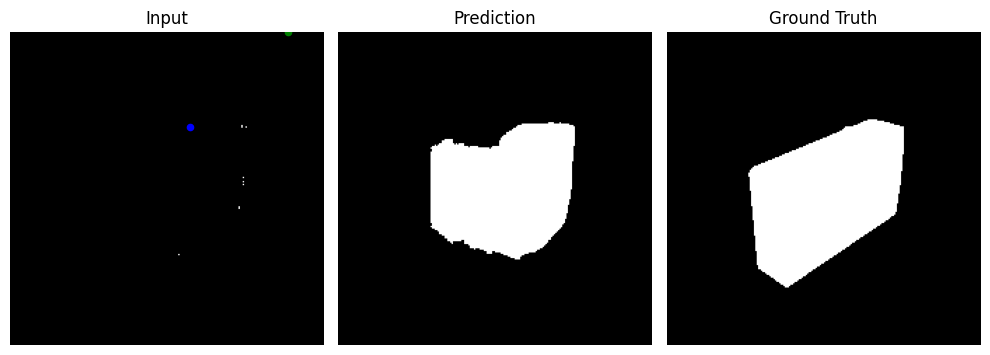

Curren loss : tensor(-0.4414, device='cuda:0')
Episode 5:
  Action Taken: [0.5569842 0.7436736]
  Reward Received: -0.4413626790046692
  Done: False, Truncated: False


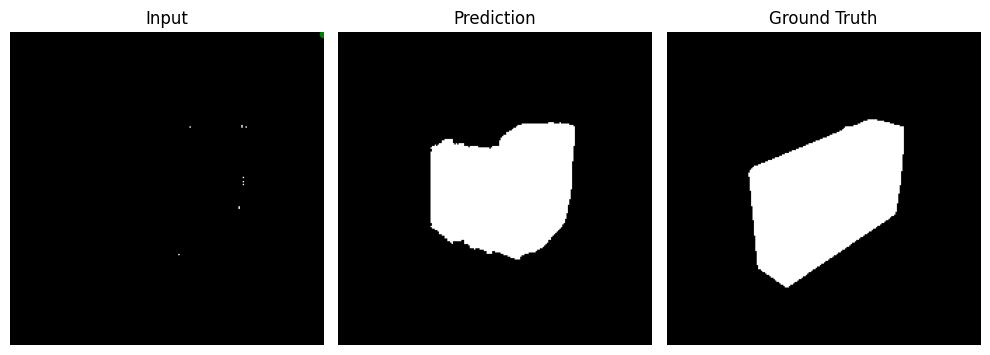

Curren loss : tensor(-0.4414, device='cuda:0')
Episode 5:
  Action Taken: [0.49533996 0.8784895 ]
  Reward Received: -0.4413626790046692
  Done: False, Truncated: False


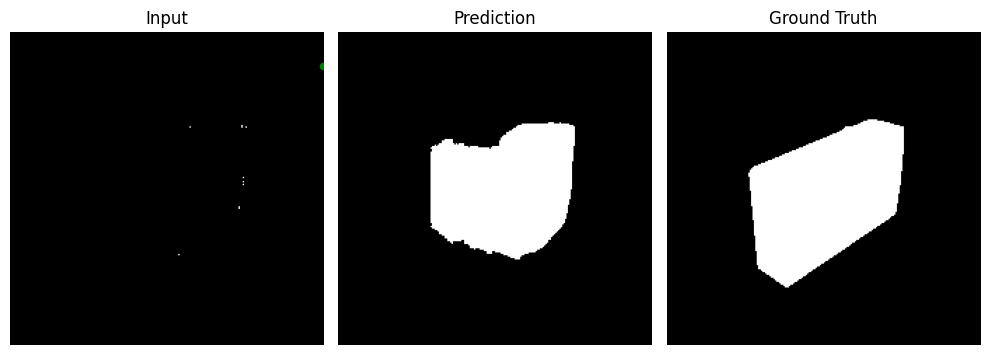

Curren loss : tensor(-0.4414, device='cuda:0')
Episode 5:
  Action Taken: [0.44389433 0.86652505]
  Reward Received: -0.4413626790046692
  Done: False, Truncated: False


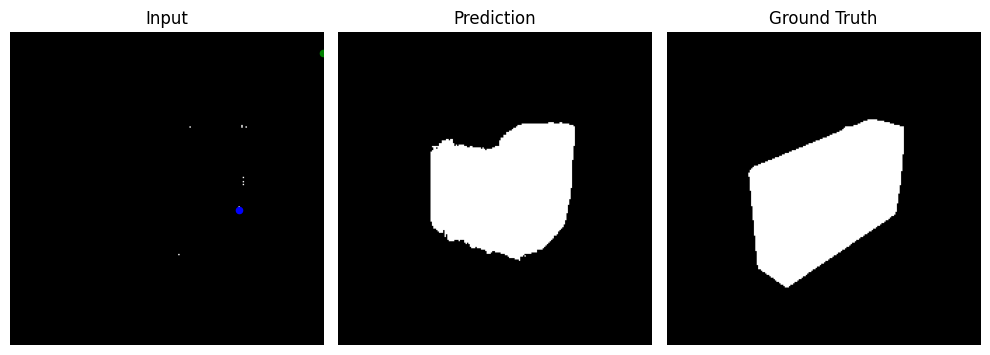

Curren loss : tensor(-0.4625, device='cuda:0')
Episode 5:
  Action Taken: [0.46421936 0.8444171 ]
  Reward Received: -0.46252891421318054
  Done: True, Truncated: False
Episode 5 finished. Resetting environment...


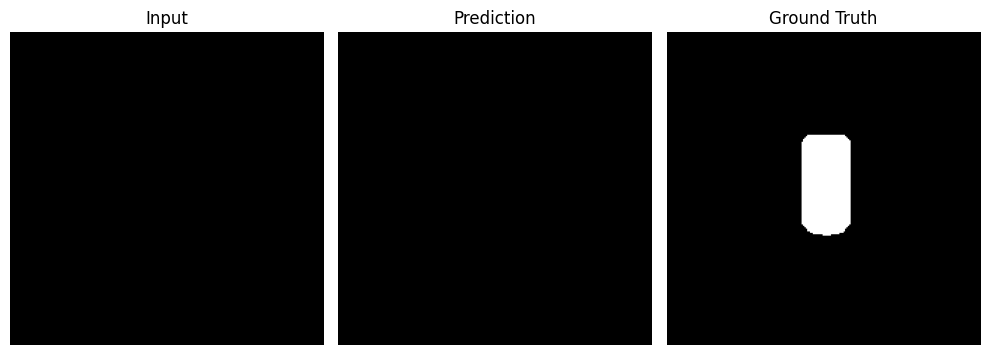

Curren loss : -2
All episodes completed. Exiting...


In [3]:
num_episodes = 5
counter = 0

print(f"Starting environment rendering for {num_episodes} episodes...")
obs, info = env.reset()
env.render()
while counter < num_episodes:
    # Get action from the model based on the current observation
    action, _ = loaded_model.predict(obs, deterministic=False)
    obs, reward, done, truncated, info = env.step(action)

    env.render()  # Render the environment for visualization

    # Provide feedback to the user
    print(f"Episode {counter + 1}:")
    print(f"  Action Taken: {action}")
    print(f"  Reward Received: {reward}")
    print(f"  Done: {done}, Truncated: {truncated}")

    if done or truncated:
        print(f"Episode {counter + 1} finished. Resetting environment...")
        counter += 1
        obs, info = env.reset()
        env.render()

print("All episodes completed. Exiting...")

env.close()











